!git clone git@github.com:deliveryhero/mkt-casestudy-ds.git

# Library Importing

In [164]:
import gzip
import shutil
import pandas as pd

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import squarify
from sklearn.cluster import KMeans
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import fpgrowth
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, \
                             classification_report, confusion_matrix, make_scorer,accuracy_score,f1_score,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import graphviz
import copy

from operator import attrgetter
import matplotlib.colors as mcolors

from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from IPython.core.display import Image, display

In [2]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
    
def plot_categorical_hist(df, max_num_of_levels=15):
    df_value_counts = df.apply(pd.value_counts)

    for col in df_value_counts.columns:
        values = df_value_counts[col]
        values = values[~pd.isnull(values)]

        if len(values) > max_num_of_levels:
            continue
    
        plt.bar(range(len(values)), values)
        plt.title(col)
        plt.show()

In [3]:
def metric_check(model_obj,xtrain,xtest,ytrain,ytest):
    
    print('Train recall: ',recall_score(ytrain, model_obj.predict(xtrain)))
    print('Test recall: ',recall_score(ytest, model_obj.predict(xtest)),'\n')

    print('Train precision: ',precision_score(ytrain, model_obj.predict(xtrain)))
    print('Test precision: ',precision_score(ytest, model_obj.predict(xtest)),'\n')

    print('Train accuracy: ', accuracy_score(ytrain, model_obj.predict(xtrain)))
    print('Test accuracy: ', accuracy_score(ytest, model_obj.predict(xtest)),'\n')

    
    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix(ytrain, model_obj.predict(xtrain)), 
                annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.title('Train confusion matrix')
    plt.show()
    

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix(ytest, model_obj.predict(xtest)), 
                annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.title('Test confusion matrix')
    plt.show()

def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

# Data Import

In [4]:
with gzip.open('mkt-casestudy-ds/data/machine_learning_challenge_labeled_data.csv.gz') as f:

    labeled_data = pd.read_csv(f)

with gzip.open('mkt-casestudy-ds/data/machine_learning_challenge_order_data.csv.gz') as f:

    order_data = pd.read_csv(f)
    
print(labeled_data.shape)

print(order_data.shape)

(245455, 2)
(786600, 13)


In [5]:
labeled_data.head()

customer_id  is_returning_customer
0  000097eabfd9                      0
1  0000e2c6d9be                      0
2  000133bb597f                      1
3  00018269939b                      0
4  0001a00468a6                      0

In [6]:
order_data.head()

customer_id  order_date  order_hour  customer_order_rank  is_failed  \
0  000097eabfd9  2015-06-20          19                  1.0          0   
1  0000e2c6d9be  2016-01-29          20                  1.0          0   
2  000133bb597f  2017-02-26          19                  1.0          0   
3  00018269939b  2017-02-05          17                  1.0          0   
4  0001a00468a6  2015-08-04          19                  1.0          0   

   voucher_amount  delivery_fee  amount_paid  restaurant_id  city_id  \
0             0.0         0.000     11.46960        5803498    20326   
1             0.0         0.000      9.55800      239303498    76547   
2             0.0         0.493      5.93658      206463498    33833   
3             0.0         0.493      9.82350       36613498    99315   
4             0.0         0.493      5.15070      225853498    16456   

   payment_id  platform_id  transmission_id  
0        1779        30231             4356  
1        1619        30359             4356  
2        1619        30359             4324  
3        1619        30359             4356  
4        1619        29463             4356

In [7]:
order_data.dtypes

customer_id             object
order_date              object
order_hour               int64
customer_order_rank    float64
is_failed                int64
voucher_amount         float64
delivery_fee           float64
amount_paid            float64
restaurant_id            int64
city_id                  int64
payment_id               int64
platform_id              int64
transmission_id          int64
dtype: object

In [8]:
df_merge=order_data.merge(labeled_data,how='left',on='customer_id')

In [9]:
print(df_merge.shape,'\n')
print(df_merge['is_returning_customer'].value_counts())

(786600, 14) 

1    408889
0    377711
Name: is_returning_customer, dtype: int64


__I assumed that i am building this model after labelset period. I approach the problem as  supervised binary classification. If it was not, i should build my target from training set with considering time domain and work on solution.__

# Data Discovery

In [10]:
df_merge.head()

customer_id  order_date  order_hour  customer_order_rank  is_failed  \
0  000097eabfd9  2015-06-20          19                  1.0          0   
1  0000e2c6d9be  2016-01-29          20                  1.0          0   
2  000133bb597f  2017-02-26          19                  1.0          0   
3  00018269939b  2017-02-05          17                  1.0          0   
4  0001a00468a6  2015-08-04          19                  1.0          0   

   voucher_amount  delivery_fee  amount_paid  restaurant_id  city_id  \
0             0.0         0.000     11.46960        5803498    20326   
1             0.0         0.000      9.55800      239303498    76547   
2             0.0         0.493      5.93658      206463498    33833   
3             0.0         0.493      9.82350       36613498    99315   
4             0.0         0.493      5.15070      225853498    16456   

   payment_id  platform_id  transmission_id  is_returning_customer  
0        1779        30231             4356                      0  
1        1619        30359             4356                      0  
2        1619        30359             4324                      1  
3        1619        30359             4356                      0  
4        1619        29463             4356                      0

In [11]:
print(df_merge['order_date'].min())
print(df_merge['order_date'].max())

2012-05-17
2017-02-27


In [12]:
df_merge2=copy.deepcopy(df_merge)

In [13]:
df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])


In [14]:
df_merge['order_date_ym']=df_merge['order_date'].dt.strftime('%Y%m')
df_merge['order_date_ym'].value_counts()

201701    57021
201612    52190
201702    50619
201610    47610
201611    47129
201607    39026
201609    37641
201608    37124
201601    35983
201605    35976
201606    35764
201603    34512
201604    33158
201602    32861
201512    29375
201511    28211
201510    25970
201509    22785
201508    22130
201505    20195
201507    19668
201506    15964
201504    13256
201503    12379
201502        8
201411        4
201310        3
201306        3
201412        3
201404        3
201309        3
201401        2
201406        2
201408        2
201407        2
201308        2
201501        2
201405        2
201303        2
201205        1
201212        1
201409        1
201208        1
201410        1
201311        1
201305        1
201209        1
201312        1
201307        1
Name: order_date_ym, dtype: int64

There are some noisy data before 201503. According to readme file description and the cosidering having less count, i will drop this rows from my dataset

In [15]:
df_merge=df_merge[df_merge['order_date']>='2015-03-01']
df_merge['order_date_ym'].value_counts()

201701    57021
201612    52190
201702    50619
201610    47610
201611    47129
201607    39026
201609    37641
201608    37124
201601    35983
201605    35976
201606    35764
201603    34512
201604    33158
201602    32861
201512    29375
201511    28211
201510    25970
201509    22785
201508    22130
201505    20195
201507    19668
201506    15964
201504    13256
201503    12379
Name: order_date_ym, dtype: int64

In [16]:
df_merge.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'is_returning_customer', 'order_date_ym'],
      dtype='object')

In [17]:
missing_values_table(df_merge)

Your selected dataframe has 15 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
customer_order_rank           24761                3.1

In [18]:
for col in ['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']:
    print('{0} value have {1} distinct values'.format(col,df_merge[col].nunique()))

restaurant_id value have 13560 distinct values
city_id value have 3749 distinct values
payment_id value have 5 distinct values
platform_id value have 14 distinct values
transmission_id value have 10 distinct values


In [19]:
df_merge[['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']]=df_merge[['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']].astype('object')

In [20]:
df_merge.dtypes

customer_id                      object
order_date               datetime64[ns]
order_hour                        int64
customer_order_rank             float64
is_failed                         int64
voucher_amount                  float64
delivery_fee                    float64
amount_paid                     float64
restaurant_id                    object
city_id                          object
payment_id                       object
platform_id                      object
transmission_id                  object
is_returning_customer             int64
order_date_ym                    object
dtype: object

In [21]:
categorical_columns=['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']
num_cols=['order_hour', 'customer_order_rank','is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid']
target=['is_returning_customer']

## EDA

In [22]:
import copy
df_merge2=copy.deepcopy(df_merge)

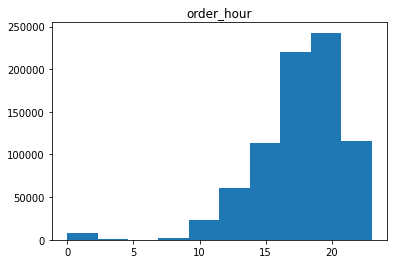

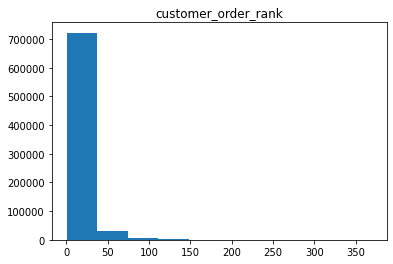

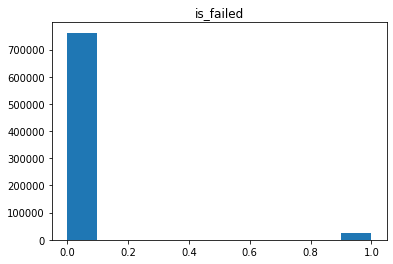

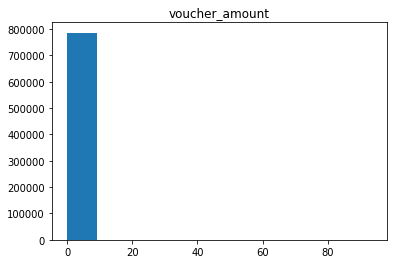

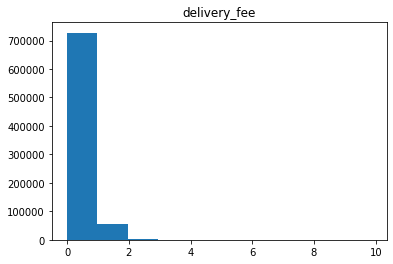

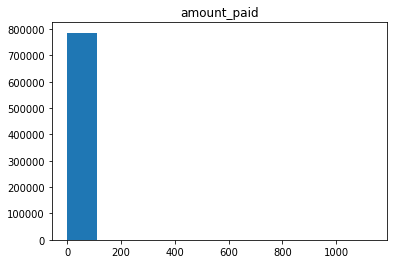

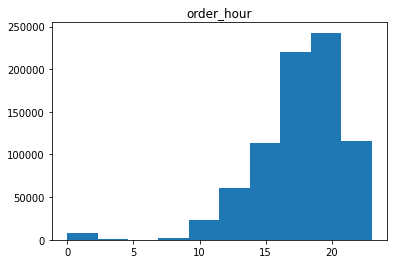

In [23]:
for index, element in enumerate(num_cols+['order_hour']):
    plt.figure(index)
    plt.hist(df_merge[element])
    plt.title(element)

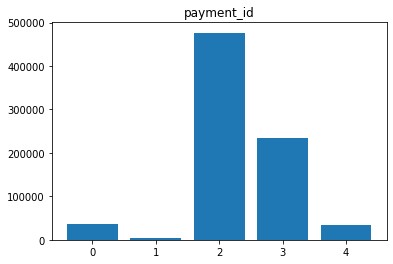

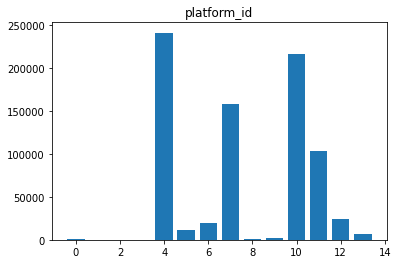

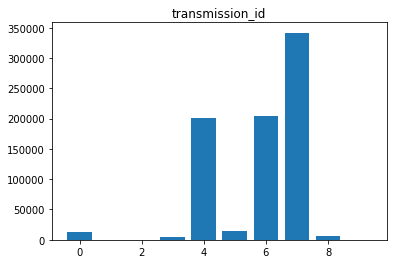

In [24]:
plot_categorical_hist(df_merge[['payment_id', 'platform_id','transmission_id']])

# Customer Level Dataset

Since we will predict to customers tend to order again, we should create a customer based table 

In [25]:
df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])

In [26]:
df_merge.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'is_returning_customer', 'order_date_ym'],
      dtype='object')

Before the group by operation we could add some features based on existing feature. We have that business knowledge, there are some people preferred meal order in weekdays or weekends. So to represent this information we add the features below.

In [27]:
df_merge['weekday'] = df_merge['order_date'].dt.strftime('%A')
df_merge['Weekend_Flag'] = 0
df_merge.loc[(df_merge['weekday'].isin(['Saturday','Sunday'])),'Weekend_Flag'] = 1

In [28]:
dcust=df_merge.groupby('customer_id').agg({'order_date':['min','max'],
                                     'customer_id':'count',
                                     'customer_order_rank':'max',
                                     'is_failed':'sum',
                                     'voucher_amount':['mean','median','sum'],
                                     'delivery_fee':['mean','median','sum'],
                                     'amount_paid':['mean','median','sum'],
                                     'is_returning_customer':'max',
                                     'city_id':'nunique',
                                     'restaurant_id':'nunique',
                                     'order_hour':['min','max','median','nunique'],
                                     'weekday':'nunique',
                                     'Weekend_Flag':'sum'
                                    })

dcust.columns=['_'.join(col) for col in dcust.columns.ravel()]
dcust.reset_index(inplace=True)

In [29]:
dcust.head()

customer_id order_date_min order_date_max  customer_id_count  \
0  000097eabfd9     2015-06-20     2015-06-20                  1   
1  0000e2c6d9be     2016-01-29     2016-01-29                  1   
2  000133bb597f     2017-02-26     2017-02-26                  1   
3  00018269939b     2017-02-05     2017-02-05                  1   
4  0001a00468a6     2015-08-04     2015-08-04                  1   

   customer_order_rank_max  is_failed_sum  voucher_amount_mean  \
0                      1.0              0                  0.0   
1                      1.0              0                  0.0   
2                      1.0              0                  0.0   
3                      1.0              0                  0.0   
4                      1.0              0                  0.0   

   voucher_amount_median  voucher_amount_sum  delivery_fee_mean  ...  \
0                    0.0                 0.0              0.000  ...   
1                    0.0                 0.0              0.000  ...   
2                    0.0                 0.0              0.493  ...   
3                    0.0                 0.0              0.493  ...   
4                    0.0                 0.0              0.493  ...   

   amount_paid_sum  is_returning_customer_max  city_id_nunique  \
0         11.46960                          0                1   
1          9.55800                          0                1   
2          5.93658                          1                1   
3          9.82350                          0                1   
4          5.15070                          0                1   

   restaurant_id_nunique  order_hour_min  order_hour_max  order_hour_median  \
0                      1              19              19               19.0   
1                      1              20              20               20.0   
2                      1              19              19               19.0   
3                      1              17              17               17.0   
4                      1              19              19               19.0   

   order_hour_nunique  weekday_nunique  Weekend_Flag_sum  
0                   1                1                 1  
1                   1                1                 0  
2                   1                1                 1  
3                   1                1                 1  
4                   1                1                 0  

[5 rows x 24 columns]

In [30]:
dcust['date_diff']=(dcust['order_date_max']-dcust['order_date_min']).dt.days

In [31]:
dcust['Recency']=(df_merge['order_date'].max()-dcust['order_date_max']).dt.days

In [32]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency'],
      dtype='object')

## RFM Analysis

__RFM analyis is one of the best and well known analysis describing the customer base based on their purchasing behavior. It is always helpful to knowing the customer base and explaining model and findings to business stakeholders.__

In [33]:
drfm=copy.deepcopy(dcust[['customer_id','Recency','customer_id_count','amount_paid_sum']])

drfm.columns=['customer_id','Recency','Frequency','Monetary']

quantiles = drfm[['Recency','Frequency','Monetary']].quantile(q=[0.25,0.5,0.75])

def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
quantiles.iloc[1,1]=1.5

In [34]:
drfm['R_score'] = drfm['Recency'].apply(R_Class,args=('Recency',quantiles))
drfm['F_score'] = drfm['Frequency'].apply(FM_Class,args=('Frequency',quantiles))
drfm['M_score'] = drfm['Monetary'].apply(FM_Class,args=('Monetary',quantiles))

drfm['RFM_Score'] = drfm['R_score'].map(str) + drfm['F_score'].map(str) + drfm['M_score'].map(str)

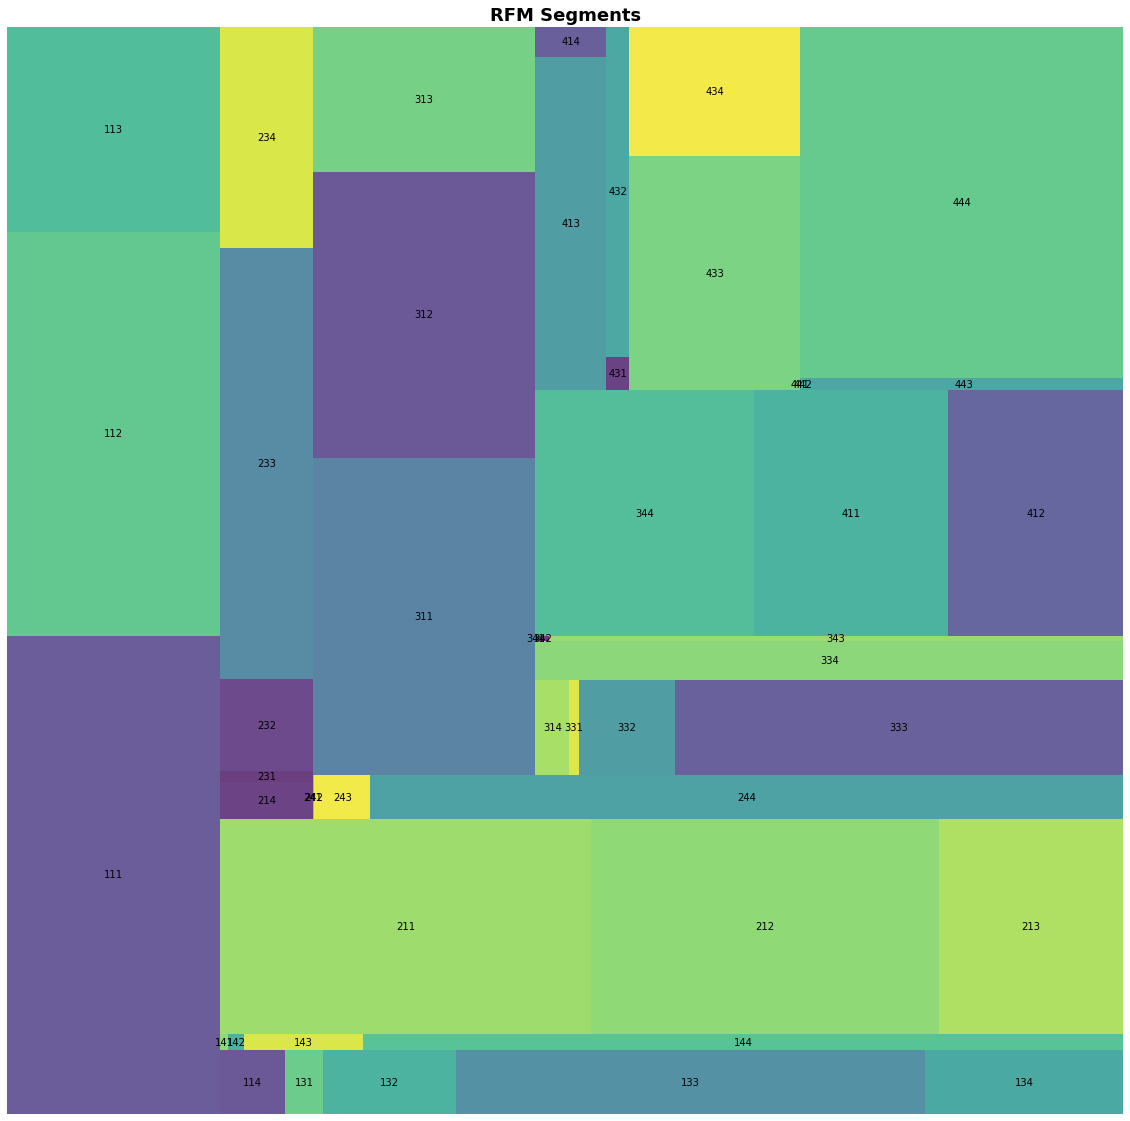

In [35]:
rfm=drfm.groupby('RFM_Score').aggregate({'Recency':'median','Monetary':'median','Frequency':'median','customer_id':'count'}).reset_index()


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 20)

squarify.plot(sizes = rfm['customer_id'], 
              label = rfm['RFM_Score'], alpha=0.8 )

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

__As it  could be seen from the square graph above, our customer base having density on '444' and '111' this tells us there are clusters like 'loyal customers' and 'churn risk customers'. It could be also said that there are many actions could be taken for upsell and retention. We store that variables also as potential modelling feature candidates.__ 

In [36]:
dcust=dcust.merge(drfm[['customer_id','R_score','F_score','M_score','RFM_Score']],how='left')

# Correlation Map

__Correlation map always gives us a sightseeing about our feature set. We should avoid from co-linear features and also think about are there any chance to turning less correlated features with target to highly informative features with using linear or nonlinear transformations. __

<AxesSubplot:>

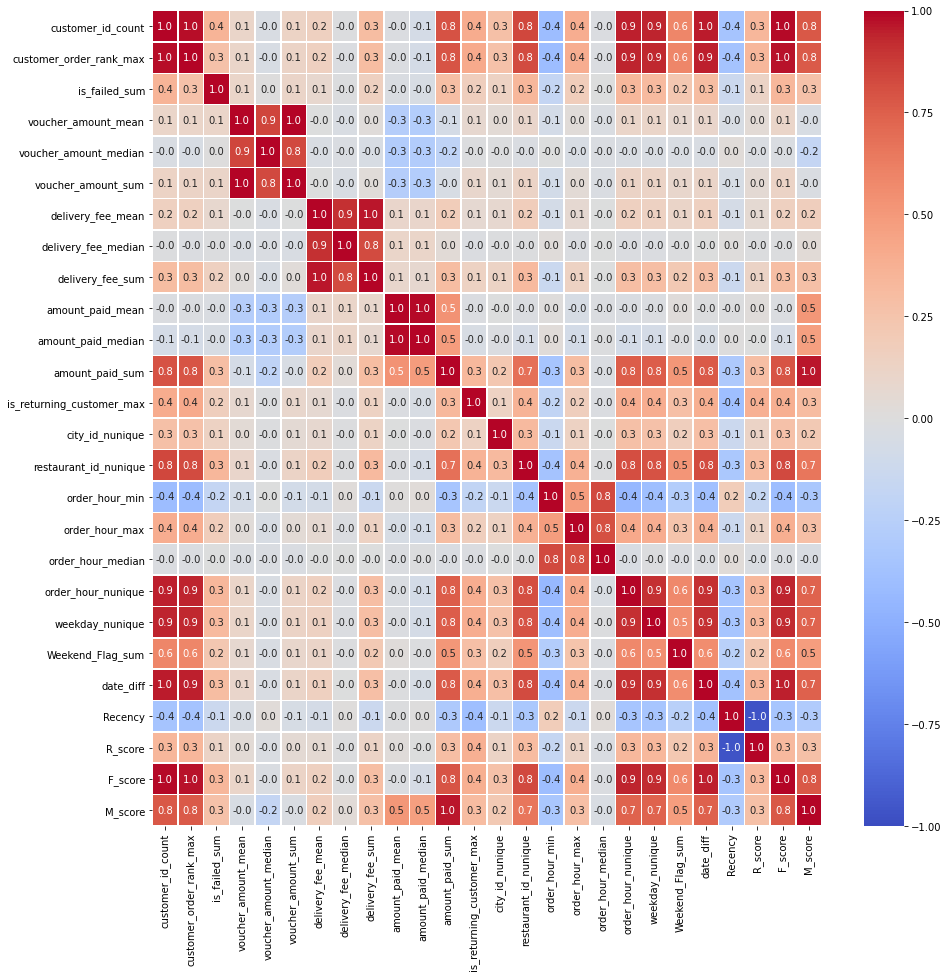

In [37]:
cols=[c for c in dcust.columns if c not in ['customer_id', 'order_date_min', 'order_date_max']]
correlation_matrix = dcust[cols].corr(method='spearman')

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(correlation_matrix, xticklabels = list(correlation_matrix), 
            yticklabels = list(correlation_matrix),
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')

## Cohort Analysis

__Cohort analysis tells about general customer lifetime after first order. It could be easily shown from the graph below we have highly flowing customer base.__

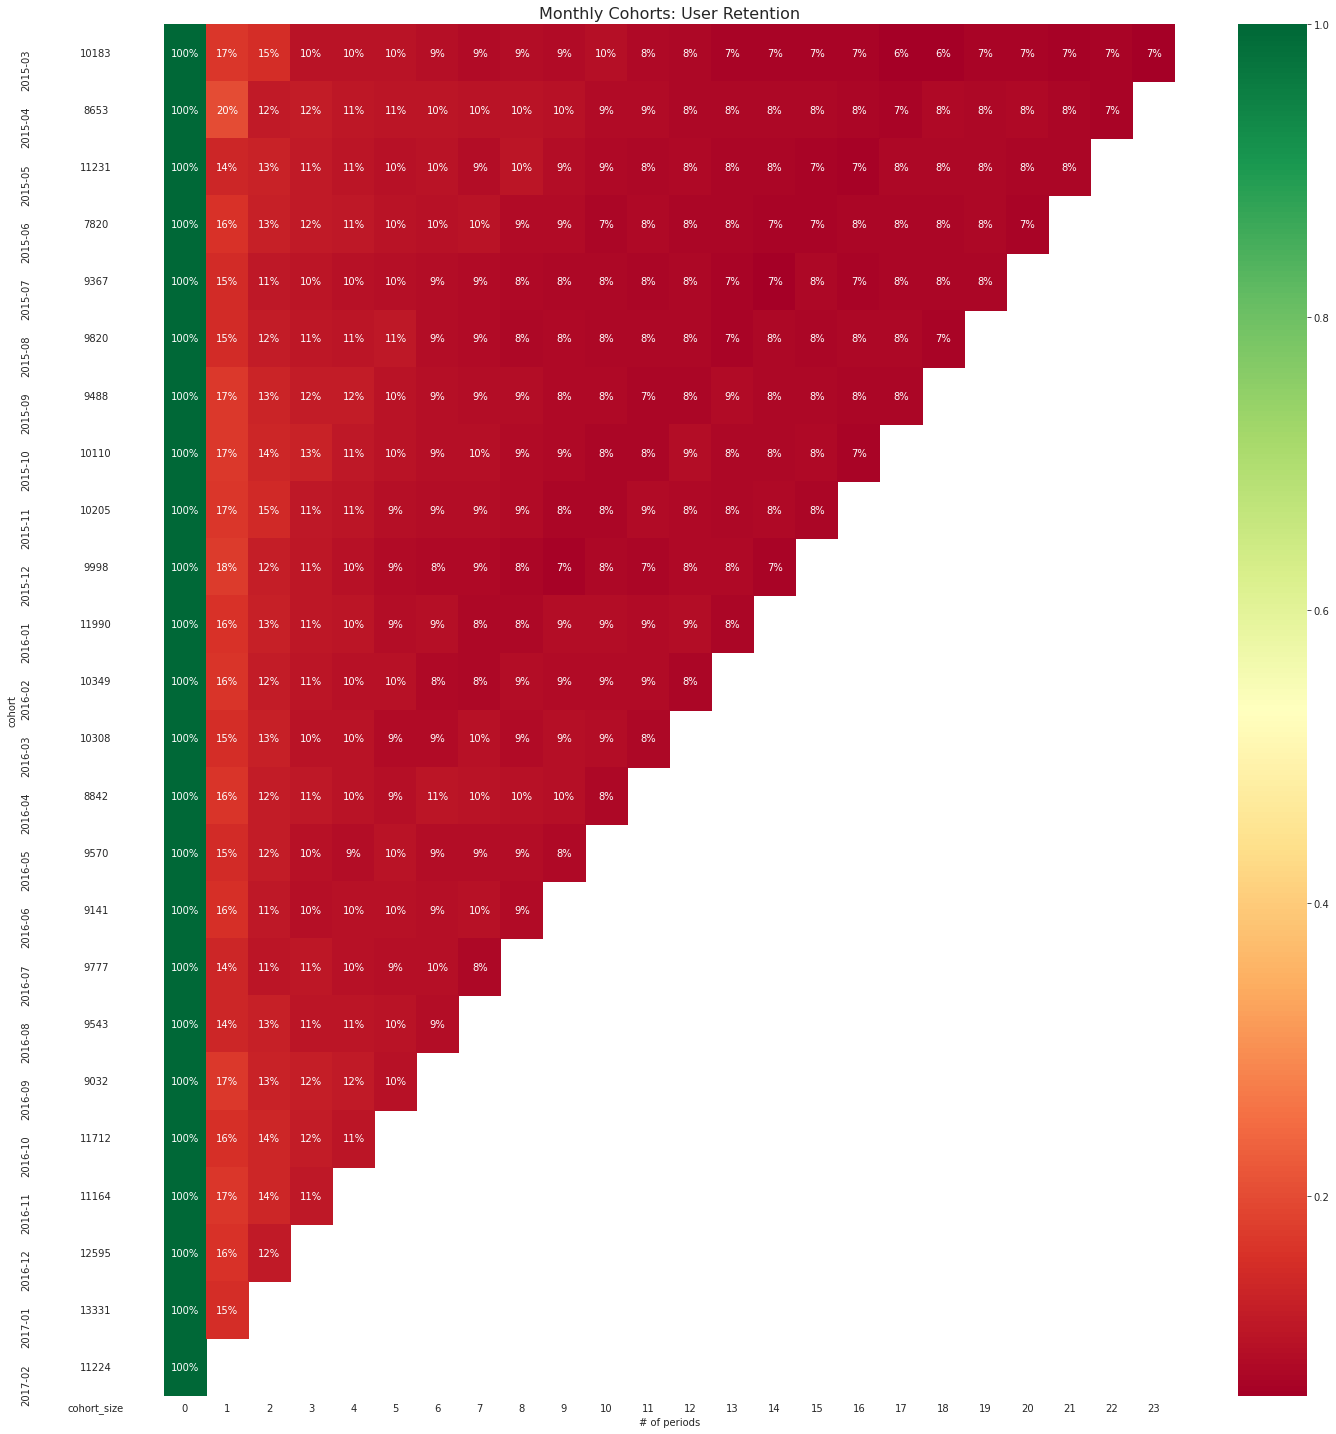

In [38]:
df_merge['Year_Month_dt']=df_merge['order_date'].dt.strftime('%Y%m')

df_merge['Year_Month_dt']=pd.to_datetime(df_merge['Year_Month_dt'].astype(str), format='%Y%m')

df_merge['cohort'] = df_merge.groupby('customer_id')['Year_Month_dt'].transform('min').dt.to_period('M') 

df_cohort = df_merge.groupby(['cohort', 'Year_Month_dt']).agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['Year_Month_dt']=df_cohort['Year_Month_dt'].dt.to_period('M') 
df_cohort = df_cohort[df_cohort['cohort']>'2015-01']


df_cohort['period_number'] = (df_cohort.Year_Month_dt - df_cohort.cohort).apply(attrgetter('n'))



cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Base Model

From start to detailed feature engineering and data wrangling more i would like to check the baseline information involving data

In [39]:
dcust['is_returning_customer_max'].value_counts()

0    189948
1     55505
Name: is_returning_customer_max, dtype: int64

In [40]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency',
       'R_score', 'F_score', 'M_score', 'RFM_Score'],
      dtype='object')

In [41]:
dcust.head(3)

customer_id order_date_min order_date_max  customer_id_count  \
0  000097eabfd9     2015-06-20     2015-06-20                  1   
1  0000e2c6d9be     2016-01-29     2016-01-29                  1   
2  000133bb597f     2017-02-26     2017-02-26                  1   

   customer_order_rank_max  is_failed_sum  voucher_amount_mean  \
0                      1.0              0                  0.0   
1                      1.0              0                  0.0   
2                      1.0              0                  0.0   

   voucher_amount_median  voucher_amount_sum  delivery_fee_mean  ...  \
0                    0.0                 0.0              0.000  ...   
1                    0.0                 0.0              0.000  ...   
2                    0.0                 0.0              0.493  ...   

   order_hour_median  order_hour_nunique  weekday_nunique  Weekend_Flag_sum  \
0               19.0                   1                1                 1   
1               20.0                   1                1                 0   
2               19.0                   1                1                 1   

   date_diff  Recency  R_score  F_score  M_score  RFM_Score  
0          0      618        1        1        2        112  
1          0      395        2        1        2        212  
2          0        1        4        1        1        411  

[3 rows x 30 columns]

In [42]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min,order_date_max','is_returning_customer_max']]
target =  'is_returning_customer_max'

X_train,X_test,ytrain,ytest = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [43]:

model_base = CatBoostClassifier()

n = ytrain.value_counts()
model_base = CatBoostClassifier(
                           learning_rate=.1,
                           iterations=1000,
                           max_depth=5,
                           l2_leaf_reg=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]], custom_loss=['AUC'])

model_base.fit(
    X_train, ytrain,
    eval_set=(X_test, ytest),
    plot = True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6585578	test: 0.6588721	best: 0.6588721 (0)	total: 204ms	remaining: 3m 23s
1:	learn: 0.6318652	test: 0.6322274	best: 0.6322274 (1)	total: 241ms	remaining: 2m
2:	learn: 0.6104552	test: 0.6110361	best: 0.6110361 (2)	total: 270ms	remaining: 1m 29s
3:	learn: 0.5936109	test: 0.5944862	best: 0.5944862 (3)	total: 306ms	remaining: 1m 16s
4:	learn: 0.5801100	test: 0.5811684	best: 0.5811684 (4)	total: 353ms	remaining: 1m 10s
5:	learn: 0.5684501	test: 0.5695909	best: 0.5695909 (5)	total: 387ms	remaining: 1m 4s
6:	learn: 0.5596925	test: 0.5607842	best: 0.5607842 (6)	total: 429ms	remaining: 1m
7:	learn: 0.5526540	test: 0.5538848	best: 0.5538848 (7)	total: 463ms	remaining: 57.4s
8:	learn: 0.5468618	test: 0.5481723	best: 0.5481723 (8)	total: 498ms	remaining: 54.8s
9:	learn: 0.5420055	test: 0.5434151	best: 0.5434151 (9)	total: 537ms	remaining: 53.2s
10:	learn: 0.5379115	test: 0.5393840	best: 0.5393840 (10)	total: 572ms	remaining: 51.4s
11:	learn: 0.5346560	test: 0.5361298	best: 0.5361298 (

96:	learn: 0.5122946	test: 0.5157624	best: 0.5157624 (96)	total: 3.79s	remaining: 35.3s
97:	learn: 0.5122621	test: 0.5157517	best: 0.5157517 (97)	total: 3.83s	remaining: 35.2s
98:	learn: 0.5122203	test: 0.5157187	best: 0.5157187 (98)	total: 3.85s	remaining: 35.1s
99:	learn: 0.5121961	test: 0.5157213	best: 0.5157187 (98)	total: 3.89s	remaining: 35s
100:	learn: 0.5121759	test: 0.5156998	best: 0.5156998 (100)	total: 3.93s	remaining: 35s
101:	learn: 0.5121627	test: 0.5156856	best: 0.5156856 (101)	total: 3.97s	remaining: 34.9s
102:	learn: 0.5121272	test: 0.5156704	best: 0.5156704 (102)	total: 4.01s	remaining: 34.9s
103:	learn: 0.5120994	test: 0.5156679	best: 0.5156679 (103)	total: 4.04s	remaining: 34.8s
104:	learn: 0.5120733	test: 0.5156486	best: 0.5156486 (104)	total: 4.08s	remaining: 34.8s
105:	learn: 0.5120481	test: 0.5156430	best: 0.5156430 (105)	total: 4.12s	remaining: 34.7s
106:	learn: 0.5120222	test: 0.5156233	best: 0.5156233 (106)	total: 4.16s	remaining: 34.7s
107:	learn: 0.5120090	

191:	learn: 0.5090752	test: 0.5149616	best: 0.5149099 (171)	total: 7.31s	remaining: 30.8s
192:	learn: 0.5090436	test: 0.5149573	best: 0.5149099 (171)	total: 7.35s	remaining: 30.7s
193:	learn: 0.5090185	test: 0.5149922	best: 0.5149099 (171)	total: 7.39s	remaining: 30.7s
194:	learn: 0.5089984	test: 0.5149920	best: 0.5149099 (171)	total: 7.42s	remaining: 30.6s
195:	learn: 0.5089508	test: 0.5149944	best: 0.5149099 (171)	total: 7.47s	remaining: 30.6s
196:	learn: 0.5089352	test: 0.5149945	best: 0.5149099 (171)	total: 7.51s	remaining: 30.6s
197:	learn: 0.5088930	test: 0.5149700	best: 0.5149099 (171)	total: 7.55s	remaining: 30.6s
198:	learn: 0.5088615	test: 0.5149932	best: 0.5149099 (171)	total: 7.58s	remaining: 30.5s
199:	learn: 0.5088256	test: 0.5149694	best: 0.5149099 (171)	total: 7.62s	remaining: 30.5s
200:	learn: 0.5088012	test: 0.5149714	best: 0.5149099 (171)	total: 7.65s	remaining: 30.4s
201:	learn: 0.5087570	test: 0.5150003	best: 0.5149099 (171)	total: 7.69s	remaining: 30.4s
202:	learn

Train recall:  0.6892622286280515
Test recall:  0.6821007116475993 

Train precision:  0.5122686037559
Test precision:  0.5111726186457841 

Train accuracy:  0.7813324370295679
Test accuracy:  0.7806115173860789 



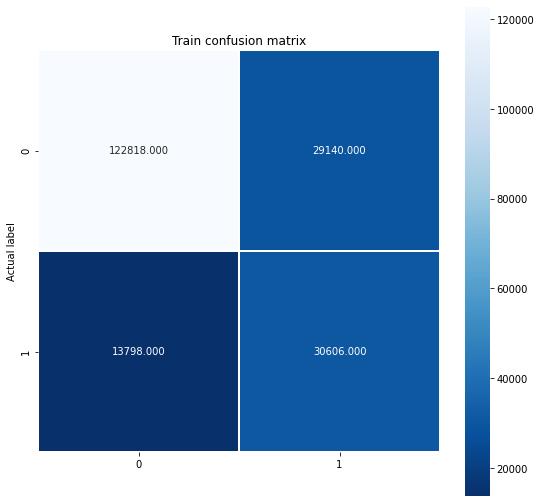

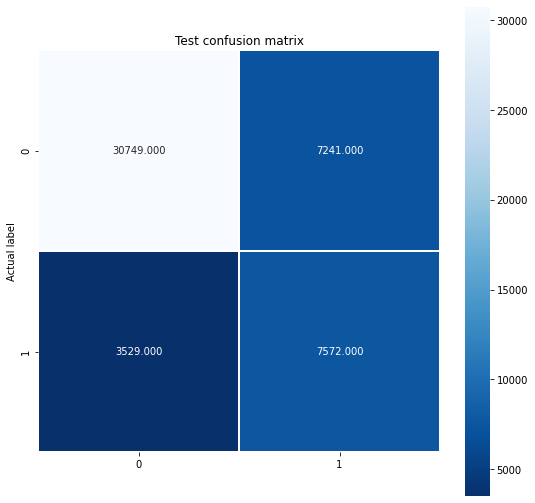

In [44]:
metric_check(model_base,X_train,X_test,ytrain,ytest)

# Improve the Model 

# Feature Engineering

In [45]:
dcust_v2=copy.deepcopy(dcust)

In [46]:
dcust.head(3)

customer_id order_date_min order_date_max  customer_id_count  \
0  000097eabfd9     2015-06-20     2015-06-20                  1   
1  0000e2c6d9be     2016-01-29     2016-01-29                  1   
2  000133bb597f     2017-02-26     2017-02-26                  1   

   customer_order_rank_max  is_failed_sum  voucher_amount_mean  \
0                      1.0              0                  0.0   
1                      1.0              0                  0.0   
2                      1.0              0                  0.0   

   voucher_amount_median  voucher_amount_sum  delivery_fee_mean  ...  \
0                    0.0                 0.0              0.000  ...   
1                    0.0                 0.0              0.000  ...   
2                    0.0                 0.0              0.493  ...   

   order_hour_median  order_hour_nunique  weekday_nunique  Weekend_Flag_sum  \
0               19.0                   1                1                 1   
1               20.0                   1                1                 0   
2               19.0                   1                1                 1   

   date_diff  Recency  R_score  F_score  M_score  RFM_Score  
0          0      618        1        1        2        112  
1          0      395        2        1        2        212  
2          0        1        4        1        1        411  

[3 rows x 30 columns]

In [47]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency',
       'R_score', 'F_score', 'M_score', 'RFM_Score'],
      dtype='object')

In [48]:
dcust.rename(columns = {'customer_id_count':'order_count',
                       'is_returning_customer_max' : 'is_returning_customer'},inplace=True)

In [49]:
df_merge.head(3)

customer_id order_date  order_hour  customer_order_rank  is_failed  \
0  000097eabfd9 2015-06-20          19                  1.0          0   
1  0000e2c6d9be 2016-01-29          20                  1.0          0   
2  000133bb597f 2017-02-26          19                  1.0          0   

   voucher_amount  delivery_fee  amount_paid restaurant_id city_id payment_id  \
0             0.0         0.000     11.46960       5803498   20326       1779   
1             0.0         0.000      9.55800     239303498   76547       1619   
2             0.0         0.493      5.93658     206463498   33833       1619   

  platform_id transmission_id  is_returning_customer order_date_ym   weekday  \
0       30231            4356                      0        201506  Saturday   
1       30359            4356                      0        201601    Friday   
2       30359            4324                      1        201702    Sunday   

   Weekend_Flag Year_Month_dt   cohort  
0             1    2015-06-01  2015-06  
1             0    2016-01-01  2016-01  
2             1    2017-02-01  2017-02

In [50]:
categorical_columns.append('weekday')
categorical_columns.append('Weekend_Flag')

In [51]:
dcust_v3 = copy.deepcopy(dcust)

In [52]:
dcust.shape

(245453, 30)

__We could add extra features using categorical features with aggragation. They gives us highly valuable variables like most paid hours, most used payment type etc. Yet, since the restaurant and city ids having high cardinality we exclude them from that operation. We will look for an extra solution for them.__ 

In [53]:
for col in categorical_columns:
    if col not in  ('restaurant_id','city_id'):
        d1 = df_merge.groupby(['customer_id',col]).agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : 'count',
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum']
                                                           })

        d1.columns=['_'.join(col) for col in d1.columns.ravel()]
        d1.reset_index(inplace=True)
        d1[col] = d1[col].astype('str')
        d2 = pd.pivot_table(d1, index = 'customer_id', columns=col, values = ['amount_paid_mean', 'amount_paid_median',
               'amount_paid_sum', 'customer_id_count', 'is_failed_sum'])

        d2.columns=['_'.join(col) for col in d2.columns.ravel()]

        d2.reset_index(inplace=True)

        d2.fillna(0, inplace = True)

        dcust=dcust.merge(d2, how = 'left', on = 'customer_id')

        print(dcust.shape)

(245453, 55)
(245453, 125)
(245453, 175)
(245453, 210)
(245453, 220)


## Have a look on city and restaurants

__City__

__To represent city as numbers, we could reduce their sizes. We could make one hot encoding but it is ineffective and it does not allow for aggregation in this data. Instead of this we could make clusters from city's having the same charachteristics. To obtain that we will use popular K means algorithm. For deciding cluster size we will use elbow method and calculate the quality of clusters with silhoutte metric__ 

In [54]:
dcust_v4 = copy.deepcopy(dcust)

In [55]:
d_cit = df_merge.groupby('city_id').agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : ['count','nunique'],
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum'],
                                                             'restaurant_id' : 'nunique',
                                                              'voucher_amount': ['mean','median','sum']

                                                           })

d_cit.columns=['_'.join(col) for col in d_cit.columns.ravel()]
d_cit.reset_index(inplace=True)

In [56]:
d_cit.head()

city_id  amount_paid_mean  amount_paid_median  amount_paid_sum  \
0      230         10.675319             9.18630      10600.59195   
1     1298         10.590538             9.61110      69039.71730   
2     1676         10.845709             9.70137        835.11963   
3     1685          8.954108             8.23581        295.48557   
4     1689         14.376825            10.48725        258.78285   

   customer_id_count  customer_id_nunique  is_failed_sum  delivery_fee_mean  \
0                993                  761             38           0.185483   
1               6519                 2316            185           0.257660   
2                 77                   40              3           0.122290   
3                 33                   21              0           0.000000   
4                 18                   11              1           0.000000   

   delivery_fee_median  delivery_fee_sum  restaurant_id_nunique  \
0                  0.0         184.18480                    719   
1                  0.0        1679.68551                     93   
2                  0.0           9.41630                     15   
3                  0.0           0.00000                      5   
4                  0.0           0.00000                      3   

   voucher_amount_mean  voucher_amount_median  voucher_amount_sum  
0             0.039765                    0.0            39.48616  
1             0.101806                    0.0           663.67070  
2             0.089091                    0.0             6.86000  
3             0.114333                    0.0             3.77300  
4             0.000000                    0.0             0.00000

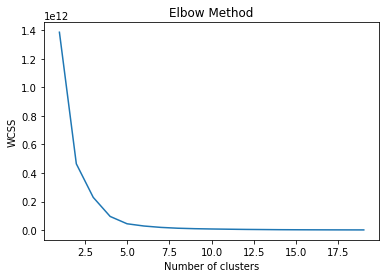

In [57]:
dtmp = copy.deepcopy(d_cit)
feat = [col for col in dtmp.columns if col!='city_id']
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dtmp[feat])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

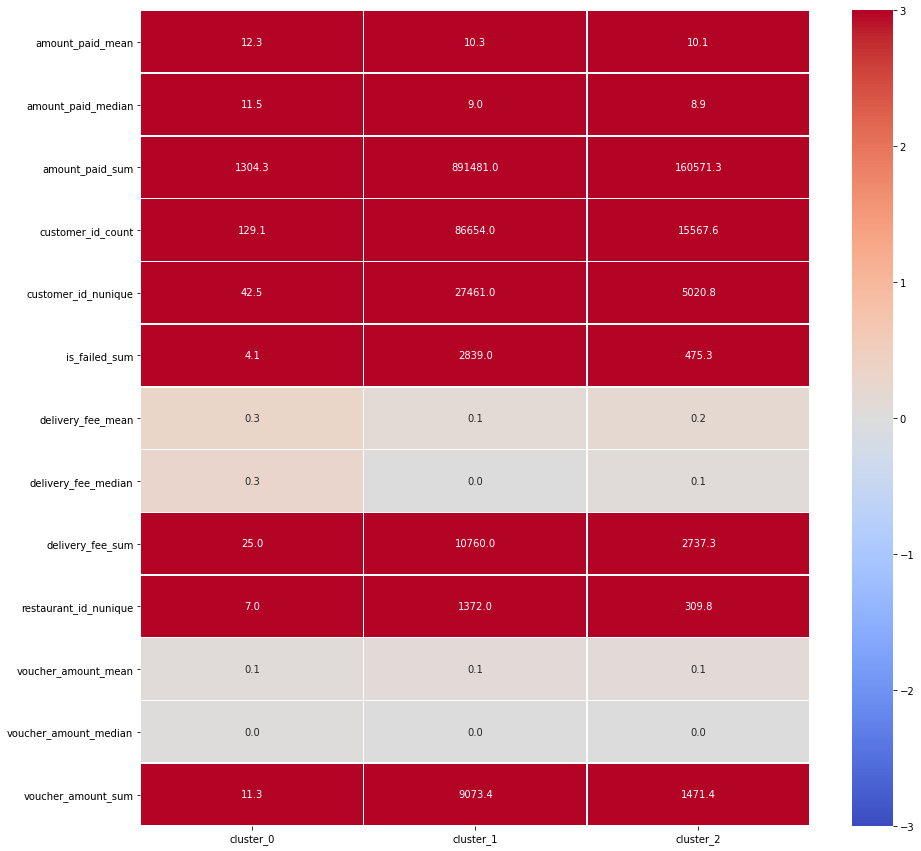

In [58]:
kmeans = KMeans(n_clusters=3,random_state= 42)
kmeans.fit(dtmp[feat])
dtmp['Cluster'] = kmeans.predict(dtmp[feat])

cluster_centers = kmeans.cluster_centers_.tolist()
cluster_centers_df = pd.DataFrame({i:centers for i, centers in enumerate(cluster_centers)}, index=feat)

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(cluster_centers_df, 
            xticklabels=['cluster_' + str(i) for i in cluster_centers_df.columns], 
            yticklabels=list(cluster_centers_df.index),
            cmap='coolwarm',
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, 
            vmin=-3, vmax=3)
plt.show()

In [59]:
dtmp['Cluster'].value_counts()

0    3734
2      14
1       1
Name: Cluster, dtype: int64

In [60]:
silhouette_score(dtmp[feat], dtmp['Cluster'], metric='euclidean')

0.9822921849765937

__The silhoutte score close the 1, our clusters so good. We could visualize them also using PCA in 2D__

In [259]:
import pickle

filename = 'kmeans_city_model.pkl'
pickle.dump(kmeans, open(filename, 'wb'))


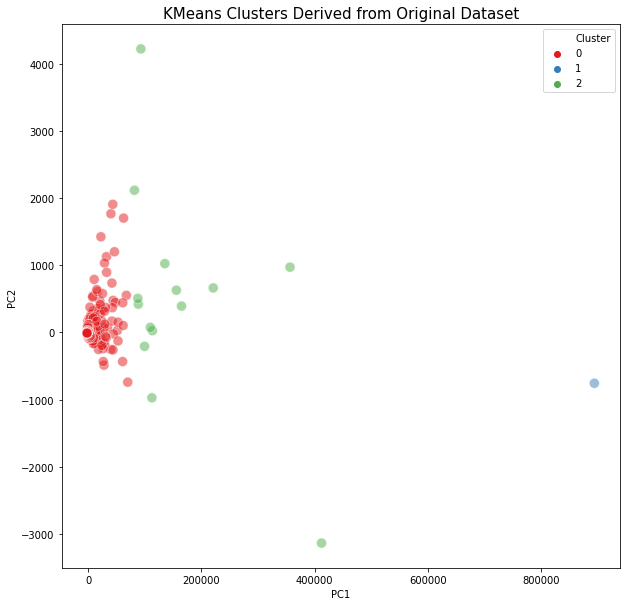

In [64]:
pca1 = PCA(n_components=2).fit(dtmp[feat])
pca2d = pca1.transform(dtmp[feat])

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=dtmp['Cluster'], 
                palette='Set1',
                s=100, alpha=0.5).set_title('KMeans Clusters Derived from Original Dataset', fontsize=15)

plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [65]:
d_cit['City_Cluster'] =  kmeans.predict(d_cit[feat])

In [66]:
df_merge = df_merge.merge(d_cit[['city_id','City_Cluster']],how='left')

__Restaurants__

We will apply the same methodology for restaurant ids. It s silhouette score is a little less but ok for continue.

In [67]:
dcust_v5 = copy.deepcopy(dcust)

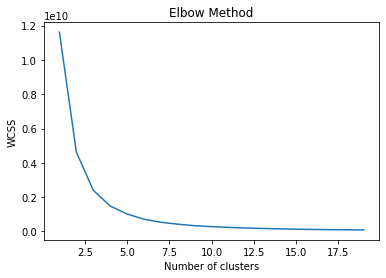

In [68]:
d_rest = df_merge.groupby('restaurant_id').agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : ['count','nunique'],
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum'],
                                                             'voucher_amount': ['mean','median','sum']
                                                           })

d_rest.columns=['_'.join(col) for col in d_rest.columns.ravel()]
d_rest.reset_index(inplace=True)

d_rest.fillna(0,inplace=True)

dtmp = copy.deepcopy(d_rest)
feat = [col for col in dtmp.columns if col!='restaurant_id']
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dtmp[feat])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

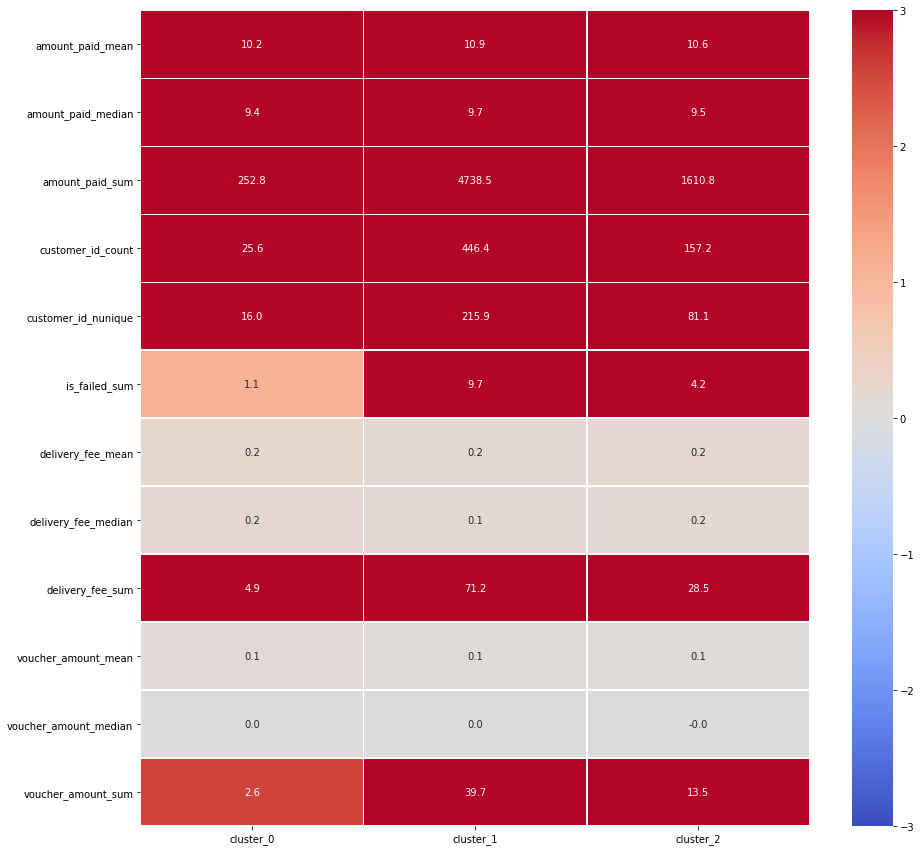

In [69]:
kmeans2 = KMeans(n_clusters=3,random_state= 42)
kmeans2.fit(dtmp[feat])
dtmp['Cluster'] = kmeans2.predict(dtmp[feat])

cluster_centers = kmeans2.cluster_centers_.tolist()
cluster_centers_df = pd.DataFrame({i:centers for i, centers in enumerate(cluster_centers)}, index=feat)

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(cluster_centers_df, 
            xticklabels=['cluster_' + str(i) for i in cluster_centers_df.columns], 
            yticklabels=list(cluster_centers_df.index),
            cmap='coolwarm',
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, 
            vmin=-3, vmax=3)
plt.show()

In [70]:
dtmp['Cluster'].value_counts()

0    10917
2     2327
1      316
Name: Cluster, dtype: int64

In [71]:
silhouette_score(dtmp[feat], dtmp['Cluster'], metric='euclidean')

0.7185286152428801

In [72]:
filename = 'kmeans_rest.sav'
pickle.dump(kmeans2, open(filename, 'wb'))

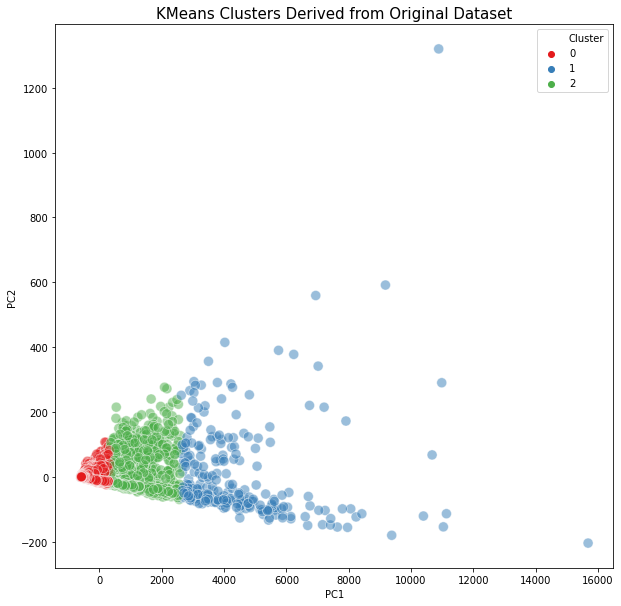

In [65]:
pca3 = PCA(n_components=2).fit(dtmp[feat])
pca2d = pca3.transform(dtmp[feat])

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=dtmp['Cluster'], 
                palette='Set1',
                s=100, alpha=0.5).set_title('KMeans Clusters Derived from Original Dataset', fontsize=15)

plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [73]:
d_rest['Restaurant_Cluster'] =  kmeans2.predict(d_rest[feat])
df_merge = df_merge.merge(d_rest[['restaurant_id','Restaurant_Cluster']],how='left')

__Adding City and Restaurant Related Features__

__Now we could add features based on city and restaurants after overcome from high cardinality problem.__

In [74]:
dcust_v6 = copy.deepcopy(dcust)

print(dcust.shape)

(245453, 220)


In [75]:
df_merge['Restaurant_Cluster'].value_counts()

2    366145
0    279344
1    141058
Name: Restaurant_Cluster, dtype: int64

In [76]:
for col in ['City_Cluster','Restaurant_Cluster']:
    d1 = df_merge.groupby(['customer_id',col]).agg({'amount_paid' : ['mean','median','sum'],
                                                       'customer_id' : 'count',
                                                       'is_failed' : 'sum',
                                                        'delivery_fee' : ['mean','median','sum']
                                                       })

    d1.columns=['_'.join(col) for col in d1.columns.ravel()]
    d1.reset_index(inplace=True)
    d1[col] = d1[col].astype('str')
    d2 = pd.pivot_table(d1, index = 'customer_id', columns=col, values = ['amount_paid_mean', 'amount_paid_median',
           'amount_paid_sum', 'customer_id_count', 'is_failed_sum'])

    d2.columns=['_'.join(col) for col in d2.columns.ravel()]

    d2.reset_index(inplace=True)

    d2.fillna(0, inplace = True)

    dcust=dcust.merge(d2, how = 'left', on = 'customer_id')

    print(dcust.shape)

(245453, 235)
(245453, 250)


In [77]:
list(dcust.columns)

['customer_id',
 'order_date_min',
 'order_date_max',
 'order_count',
 'customer_order_rank_max',
 'is_failed_sum',
 'voucher_amount_mean',
 'voucher_amount_median',
 'voucher_amount_sum',
 'delivery_fee_mean',
 'delivery_fee_median',
 'delivery_fee_sum',
 'amount_paid_mean',
 'amount_paid_median',
 'amount_paid_sum',
 'is_returning_customer',
 'city_id_nunique',
 'restaurant_id_nunique',
 'order_hour_min',
 'order_hour_max',
 'order_hour_median',
 'order_hour_nunique',
 'weekday_nunique',
 'Weekend_Flag_sum',
 'date_diff',
 'Recency',
 'R_score',
 'F_score',
 'M_score',
 'RFM_Score',
 'amount_paid_mean_1491',
 'amount_paid_mean_1523',
 'amount_paid_mean_1619',
 'amount_paid_mean_1779',
 'amount_paid_mean_1811',
 'amount_paid_median_1491',
 'amount_paid_median_1523',
 'amount_paid_median_1619',
 'amount_paid_median_1779',
 'amount_paid_median_1811',
 'amount_paid_sum_1491',
 'amount_paid_sum_1523',
 'amount_paid_sum_1619',
 'amount_paid_sum_1779',
 'amount_paid_sum_1811',
 'customer_id

In [78]:
categorical_columns

['restaurant_id',
 'city_id',
 'payment_id',
 'platform_id',
 'transmission_id',
 'weekday',
 'Weekend_Flag']

## Feature Selection

__To make an applicable model and get rid of co linearity we must make a feature selection__

In [79]:
dcust_v7 = copy.deepcopy(dcust)

In [80]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min,order_date_max','is_returning_customer']]
target =  'is_returning_customer'

__Correlation__

We wil drop the colinear features. To decide which feature we hold among co linear pairs we look the correlation with target and keep the better one. Since we have a binary label we will use spearman correlation more robust about binary values.

In [81]:
correlation_matrix = dcust[features].corr(method='spearman')

In [82]:
num_variables = len(correlation_matrix)
correlation_value = 0.60
correlated_variables = []

for row in range(1,num_variables):
    for col in range(0,row):
        if abs(correlation_matrix.iloc[row,col]) >= correlation_value:
            print('The variable {0} is correlated with the variable {1} by a factor of {2}'.format(list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]))
            correlated_variables.append([list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]])


The variable customer_order_rank_max is correlated with the variable order_count by a factor of 0.9835908495592898
The variable voucher_amount_median is correlated with the variable voucher_amount_mean by a factor of 0.8512241587107638
The variable voucher_amount_sum is correlated with the variable voucher_amount_mean by a factor of 0.9978984742261012
The variable voucher_amount_sum is correlated with the variable voucher_amount_median by a factor of 0.8292575255288304
The variable delivery_fee_median is correlated with the variable delivery_fee_mean by a factor of 0.9133945440014903
The variable delivery_fee_sum is correlated with the variable delivery_fee_mean by a factor of 0.9667826765660676
The variable delivery_fee_sum is correlated with the variable delivery_fee_median by a factor of 0.8210125913580437
The variable amount_paid_median is correlated with the variable amount_paid_mean by a factor of 0.9881094815642204
The variable amount_paid_sum is correlated with the variable ord

In [83]:
correlated_variables = sorted(correlated_variables, key=lambda value: abs(value[-1]), reverse=True)
correlated_variables

[['amount_paid_median_22167', 'amount_paid_mean_22167', 1.0],
 ['amount_paid_median_22295', 'amount_paid_mean_22295', 1.0],
 ['amount_paid_sum_22167', 'amount_paid_mean_22167', 1.0],
 ['amount_paid_sum_22167', 'amount_paid_median_22167', 1.0],
 ['amount_paid_sum_22295', 'amount_paid_mean_22295', 1.0],
 ['amount_paid_sum_22295', 'amount_paid_median_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_mean_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_median_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_sum_22295', 1.0],
 ['amount_paid_median_2020', 'amount_paid_mean_2020', 1.0],
 ['amount_paid_sum_2020', 'amount_paid_mean_2020', 1.0],
 ['amount_paid_sum_2020', 'amount_paid_median_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_mean_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_median_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_sum_2020', 1.0],
 ['is_failed_sum_2020', 'amount_paid_mean_2020', 1.0],
 ['is_failed_sum_2020', 'amount_paid_median

In [84]:
columns_to_delete_correlation_target = []
for element in correlated_variables:
    if element[0] not in list(dcust) or element[1] not in list(dcust):
        break
    else:
        first = dcust.is_returning_customer.corr(dcust[element[0]], method='spearman')
        second = dcust.is_returning_customer.corr(dcust[element[1]], method='spearman')
        if abs(first) > abs(second):
            print('The variable {0} is more correlated with the target'.format(element[0]))
            columns_to_delete_correlation_target.append(element[1])
        else: 
            print('The variable {0} is more correlated with the target'.format(element[1]))
            columns_to_delete_correlation_target.append(element[0])
        print(str({element[0]: first, element[1]: second}))

columns_to_delete_correlation_target = list(set(columns_to_delete_correlation_target))
dcust.drop(columns_to_delete_correlation_target, axis=1, inplace=True)

The variable amount_paid_mean_22167 is more correlated with the target
{'amount_paid_median_22167': 0.0008959248041035878, 'amount_paid_mean_22167': 0.0008959248041035878}
The variable amount_paid_mean_22295 is more correlated with the target
{'amount_paid_median_22295': 0.0037339459016027523, 'amount_paid_mean_22295': 0.0037339459016027523}
The variable amount_paid_mean_22167 is more correlated with the target
{'amount_paid_sum_22167': 0.0008959248041035878, 'amount_paid_mean_22167': 0.0008959248041035878}
The variable amount_paid_median_22167 is more correlated with the target
{'amount_paid_sum_22167': 0.0008959248041035878, 'amount_paid_median_22167': 0.0008959248041035878}
The variable amount_paid_mean_22295 is more correlated with the target
{'amount_paid_sum_22295': 0.0037339459016027523, 'amount_paid_mean_22295': 0.0037339459016027523}
The variable amount_paid_median_22295 is more correlated with the target
{'amount_paid_sum_22295': 0.0037339459016027523, 'amount_paid_median_222

The variable amount_paid_mean_212 is more correlated with the target
{'amount_paid_median_212': 0.11785154107932905, 'amount_paid_mean_212': 0.11786000206305383}
The variable amount_paid_mean_30199 is more correlated with the target
{'amount_paid_sum_30199': -0.0006149796535212545, 'amount_paid_mean_30199': -0.0006386065012963486}
The variable amount_paid_median_30199 is more correlated with the target
{'amount_paid_sum_30199': -0.0006149796535212545, 'amount_paid_median_30199': -0.0006397472295427647}
The variable amount_paid_mean_4260 is more correlated with the target
{'amount_paid_median_4260': 0.06438838752993462, 'amount_paid_mean_4260': 0.06441275365085464}
The variable amount_paid_sum_1523 is more correlated with the target
{'amount_paid_sum_1523': 0.0470472167258175, 'amount_paid_mean_1523': 0.046999204243098225}
The variable amount_paid_sum_1523 is more correlated with the target
{'amount_paid_sum_1523': 0.0470472167258175, 'amount_paid_median_1523': 0.046997530912369086}
The

The variable amount_paid_mean_30391 is more correlated with the target
{'amount_paid_sum_30391': -0.012956771997266397, 'amount_paid_mean_30391': -0.014137333493278436}
The variable amount_paid_mean_1779 is more correlated with the target
{'amount_paid_median_1779': 0.11966997826360978, 'amount_paid_mean_1779': 0.12173625073818584}
The variable amount_paid_median_2_x is more correlated with the target
{'amount_paid_median_2_x': -0.003179510963134189, 'amount_paid_mean_2_x': -0.0010405269709687858}
The variable amount_paid_median_30391 is more correlated with the target
{'amount_paid_sum_30391': -0.012956771997266397, 'amount_paid_median_30391': -0.014187362817729532}
The variable amount_paid_sum_1811 is more correlated with the target
{'amount_paid_sum_1811': 0.0885743123589305, 'amount_paid_median_1811': 0.08650212641386133}
The variable customer_id_count_525 is more correlated with the target
{'customer_id_count_525': -0.0072709931477966516, 'amount_paid_sum_525': -0.0072490781373367

The variable customer_id_count_Tuesday is more correlated with the target
{'customer_id_count_Tuesday': 0.22581845655501087, 'amount_paid_sum_Tuesday': 0.22149026171997227}
The variable customer_id_count_Wednesday is more correlated with the target
{'customer_id_count_Wednesday': 0.2241708426304282, 'amount_paid_sum_Wednesday': 0.21947240366497586}
The variable customer_id_count_1491 is more correlated with the target
{'customer_id_count_1491': 0.051387995490792836, 'amount_paid_mean_1491': 0.04922560850022106}
The variable customer_id_count_1491 is more correlated with the target
{'customer_id_count_1491': 0.051387995490792836, 'amount_paid_median_1491': 0.04914354448517616}
The variable amount_paid_median_1_y is more correlated with the target
{'customer_id_count_1_y': -0.00548627156245356, 'amount_paid_median_1_y': -0.013131149266388942}
The variable customer_id_count_30359 is more correlated with the target
{'customer_id_count_30359': 0.09305197643545837, 'amount_paid_sum_30359': 0

The variable customer_id_count_29815 is more correlated with the target
{'customer_id_count_29815': 0.0937372135199857, 'amount_paid_mean_29815': 0.07087367507935446}
The variable customer_id_count_Monday is more correlated with the target
{'customer_id_count_Monday': 0.22542496107424875, 'amount_paid_median_Monday': 0.20189378146618048}
The variable customer_id_count_Thursday is more correlated with the target
{'customer_id_count_Thursday': 0.22912996755803602, 'amount_paid_mean_Thursday': 0.20455250895533125}
The variable customer_id_count_29815 is more correlated with the target
{'customer_id_count_29815': 0.0937372135199857, 'amount_paid_median_29815': 0.06952451921571216}
The variable customer_id_count_30359 is more correlated with the target
{'customer_id_count_30359': 0.09305197643545837, 'amount_paid_mean_30359': 0.07299166465406325}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_sum_29463': 

The variable order_hour_nunique is more correlated with the target
{'F_score': 0.388023253204319, 'order_hour_nunique': 0.39310484140880647}
The variable customer_order_rank_max is more correlated with the target
{'weekday_nunique': 0.3933833197599235, 'customer_order_rank_max': 0.40948431233407784}
The variable customer_id_count_4324 is more correlated with the target
{'customer_id_count_4324': 0.160095105489522, 'amount_paid_mean_4324': 0.10261716592816475}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_mean_29463': 0.04128391850788079}
The variable customer_id_count_4324 is more correlated with the target
{'customer_id_count_4324': 0.160095105489522, 'amount_paid_median_4324': 0.10001691966712785}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_median_29463': 0.03881000028960858}
The variable weekday_nunique is m

The variable order_count is more correlated with the target
{'M_score': 0.3070984869695738, 'order_count': 0.4028404865042404}
The variable amount_paid_sum_1_x is more correlated with the target
{'amount_paid_sum_1_x': 0.26008090853969146, 'amount_paid_sum_Sunday': 0.24253824278369893}
The variable is_failed_sum is more correlated with the target
{'is_failed_sum_0_y': 0.13227860814009282, 'is_failed_sum': 0.16511045247636438}
The variable F_score is more correlated with the target
{'M_score': 0.3070984869695738, 'F_score': 0.388023253204319}
The variable Weekend_Flag_sum is more correlated with the target
{'amount_paid_sum_Sunday': 0.24253824278369893, 'Weekend_Flag_sum': 0.28208064816600703}
The variable customer_id_count_1_x is more correlated with the target
{'customer_id_count_1_x': 0.28208064816600703, 'amount_paid_sum_Sunday': 0.24253824278369893}
The variable customer_order_rank_max is more correlated with the target
{'M_score': 0.3070984869695738, 'customer_order_rank_max': 0.4

The variable customer_id_count_0_y is more correlated with the target
{'customer_id_count_2_x': 0.03638781897060718, 'customer_id_count_0_y': 0.17391448662511136}
The variable customer_id_count_0_y is more correlated with the target
{'customer_id_count_0_y': 0.17391448662511136, 'amount_paid_sum_2_x': 0.033518731040255025}
The variable amount_paid_sum_1_x is more correlated with the target
{'amount_paid_sum_1_x': 0.26008090853969146, 'amount_paid_sum_Saturday': 0.21385920772772424}
The variable Weekend_Flag_sum is more correlated with the target
{'amount_paid_sum_Saturday': 0.21385920772772424, 'Weekend_Flag_sum': 0.28208064816600703}
The variable customer_id_count_1_x is more correlated with the target
{'customer_id_count_1_x': 0.28208064816600703, 'amount_paid_sum_Saturday': 0.21385920772772424}
The variable customer_id_count_2_x is more correlated with the target
{'customer_id_count_2_x': 0.03638781897060718, 'amount_paid_median_0_y': 0.008658515459949659}
The variable amount_paid_m

In [97]:
dcust.shape

(245453, 86)

__Zero Importance Feature Elimination__

After the drop colinear features, there could be still redundant variables. There are some  ways to obtain them like Boruta algorithm. We will follow a voing strategy. We build several lightgbm models with different random states and drop the features never used in weak trees among all of the ensembles. 

In [86]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min','order_date_max','is_returning_customer']]

In [87]:
dcust['RFM_Score'] = dcust['RFM_Score'].astype('int32')

In [88]:
X_train, X_test, y_train, y_test = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [89]:
from lightgbm import LGBMClassifier

In [90]:
feature_importances = np.zeros(X_train[features].shape[1])

# Create the model with several hyperparameters


for i in range(10):
    
    model = LGBMClassifier(objective='binary', boosting_type = 'gbdt', n_estimators = 500,random_state=i)

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X_train[features], y_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'logloss', verbose = 0)
    
    # Record the feature importances
    feature_importances += model.feature_importances_
    
feature_importances = feature_importances / 10
feature_importances = pd.DataFrame({'feature': list(X_train[features].columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))


There are 15 features with 0.0 importance


In [91]:
features=[col for col in features if col not in zero_features]

In [92]:
len(features)

67

__It s well known fact that most of the information in tabular dataset comes from a little features. To reduce the complexity and gain from the calculation time we will cover the features creating the %98 of feature importance__

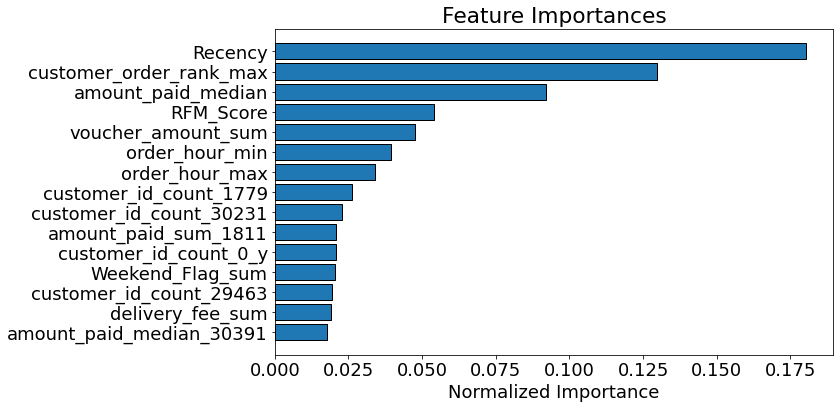

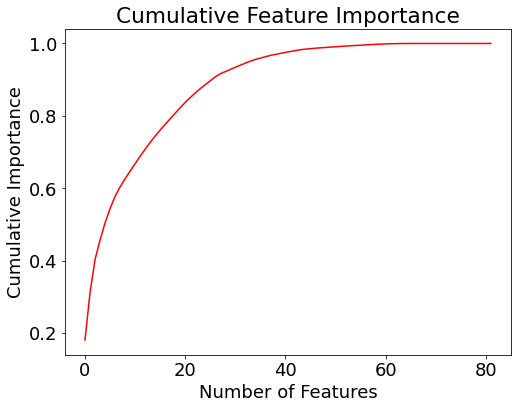

43 features required for 0.98 of cumulative importance


In [93]:
norm_feature_importances = plot_feature_importances(feature_importances,0.98)

In [94]:
threshold = 0.98

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])
features=features_to_keep

__It provides us %30 computational cost efficiency___ 

In [95]:
len(features)

42

## Modelling Part

In [96]:
X_train, X_test, y_train, y_test = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

__Model with the base Model Parameters__

Now we will build a model with baseline model parameters with new features, using Yandex's Catboost algorithm.

In [98]:
n = y_train.value_counts()
model_base2 = CatBoostClassifier(
                           learning_rate=.1,
                           iterations=1000,
                           max_depth=5,
                           l2_leaf_reg=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]], custom_loss=['AUC'])

model_base2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot = True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6592117	test: 0.6594435	best: 0.6594435 (0)	total: 51.7ms	remaining: 51.6s
1:	learn: 0.6323133	test: 0.6328023	best: 0.6328023 (1)	total: 95ms	remaining: 47.4s
2:	learn: 0.6102140	test: 0.6107903	best: 0.6107903 (2)	total: 138ms	remaining: 46s
3:	learn: 0.5930772	test: 0.5937482	best: 0.5937482 (3)	total: 181ms	remaining: 45.1s
4:	learn: 0.5794408	test: 0.5802850	best: 0.5802850 (4)	total: 223ms	remaining: 44.4s
5:	learn: 0.5688126	test: 0.5698203	best: 0.5698203 (5)	total: 268ms	remaining: 44.5s
6:	learn: 0.5607430	test: 0.5618131	best: 0.5618131 (6)	total: 320ms	remaining: 45.4s
7:	learn: 0.5529162	test: 0.5540183	best: 0.5540183 (7)	total: 368ms	remaining: 45.6s
8:	learn: 0.5481059	test: 0.5493409	best: 0.5493409 (8)	total: 416ms	remaining: 45.9s
9:	learn: 0.5435861	test: 0.5448671	best: 0.5448671 (9)	total: 464ms	remaining: 46s
10:	learn: 0.5402197	test: 0.5415546	best: 0.5415546 (10)	total: 508ms	remaining: 45.7s
11:	learn: 0.5369496	test: 0.5382786	best: 0.5382786 (11

98:	learn: 0.5137008	test: 0.5164131	best: 0.5164131 (98)	total: 4.24s	remaining: 38.6s
99:	learn: 0.5136771	test: 0.5163931	best: 0.5163931 (99)	total: 4.28s	remaining: 38.6s
100:	learn: 0.5136488	test: 0.5163713	best: 0.5163713 (100)	total: 4.33s	remaining: 38.5s
101:	learn: 0.5136081	test: 0.5163710	best: 0.5163710 (101)	total: 4.38s	remaining: 38.5s
102:	learn: 0.5135873	test: 0.5163627	best: 0.5163627 (102)	total: 4.42s	remaining: 38.5s
103:	learn: 0.5135720	test: 0.5163543	best: 0.5163543 (103)	total: 4.46s	remaining: 38.5s
104:	learn: 0.5135580	test: 0.5163438	best: 0.5163438 (104)	total: 4.5s	remaining: 38.4s
105:	learn: 0.5135263	test: 0.5163224	best: 0.5163224 (105)	total: 4.54s	remaining: 38.3s
106:	learn: 0.5134654	test: 0.5163058	best: 0.5163058 (106)	total: 4.58s	remaining: 38.3s
107:	learn: 0.5134421	test: 0.5162866	best: 0.5162866 (107)	total: 4.63s	remaining: 38.2s
108:	learn: 0.5134119	test: 0.5162534	best: 0.5162534 (108)	total: 4.67s	remaining: 38.2s
109:	learn: 0.5

191:	learn: 0.5100434	test: 0.5154060	best: 0.5154060 (191)	total: 8.28s	remaining: 34.9s
192:	learn: 0.5099997	test: 0.5154069	best: 0.5154060 (191)	total: 8.33s	remaining: 34.8s
193:	learn: 0.5099709	test: 0.5153796	best: 0.5153796 (193)	total: 8.37s	remaining: 34.8s
194:	learn: 0.5099310	test: 0.5153725	best: 0.5153725 (194)	total: 8.42s	remaining: 34.7s
195:	learn: 0.5098825	test: 0.5153829	best: 0.5153725 (194)	total: 8.46s	remaining: 34.7s
196:	learn: 0.5098580	test: 0.5153825	best: 0.5153725 (194)	total: 8.5s	remaining: 34.7s
197:	learn: 0.5098136	test: 0.5153964	best: 0.5153725 (194)	total: 8.54s	remaining: 34.6s
198:	learn: 0.5097839	test: 0.5153883	best: 0.5153725 (194)	total: 8.59s	remaining: 34.6s
199:	learn: 0.5097484	test: 0.5153623	best: 0.5153623 (199)	total: 8.63s	remaining: 34.5s
200:	learn: 0.5097026	test: 0.5153655	best: 0.5153623 (199)	total: 8.67s	remaining: 34.5s
201:	learn: 0.5096863	test: 0.5153625	best: 0.5153623 (199)	total: 8.71s	remaining: 34.4s
202:	learn:

286:	learn: 0.5074586	test: 0.5152084	best: 0.5151432 (268)	total: 12.1s	remaining: 30s
287:	learn: 0.5074365	test: 0.5152040	best: 0.5151432 (268)	total: 12.1s	remaining: 30s
288:	learn: 0.5074054	test: 0.5152058	best: 0.5151432 (268)	total: 12.2s	remaining: 29.9s
289:	learn: 0.5073967	test: 0.5152062	best: 0.5151432 (268)	total: 12.2s	remaining: 29.9s
290:	learn: 0.5073704	test: 0.5152026	best: 0.5151432 (268)	total: 12.3s	remaining: 29.8s
291:	learn: 0.5073437	test: 0.5151983	best: 0.5151432 (268)	total: 12.3s	remaining: 29.8s
292:	learn: 0.5073353	test: 0.5151911	best: 0.5151432 (268)	total: 12.3s	remaining: 29.8s
293:	learn: 0.5073057	test: 0.5152059	best: 0.5151432 (268)	total: 12.4s	remaining: 29.7s
294:	learn: 0.5072660	test: 0.5152056	best: 0.5151432 (268)	total: 12.4s	remaining: 29.6s
295:	learn: 0.5072280	test: 0.5151930	best: 0.5151432 (268)	total: 12.4s	remaining: 29.6s
296:	learn: 0.5071864	test: 0.5151990	best: 0.5151432 (268)	total: 12.5s	remaining: 29.5s
297:	learn: 0.

Train recall:  0.6876857940726061
Test recall:  0.6774164489685613 

Train precision:  0.5172962900220227
Test precision:  0.5138366928595832 

Train accuracy:  0.7842657948075493
Test accuracy:  0.7821189220019963 



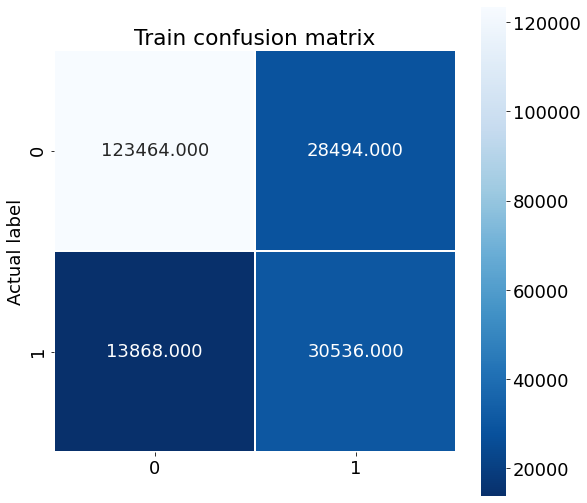

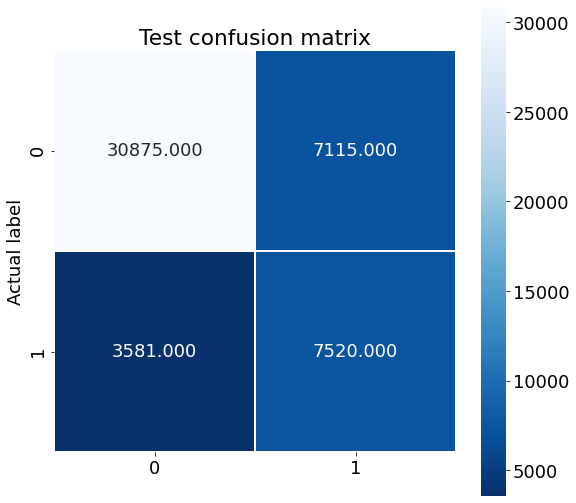

In [99]:
metric_check(model_base2,X_train,X_test,y_train,y_test)

There is slightly improvement on accuracy.

In [100]:
import pickle

filename = 'model_base2_cb.pkl'
pickle.dump(model_base2, open(filename, 'wb'))


In [102]:
features_base=copy.deepcopy(features)

__Random Search with LGBM__

__Now we will search for hyperparameters. Randomsearch is a good way to find a goodparameter set. We will use Microsoft's LightGBM algorithm.__

In [103]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(2, 50), 
             'min_child_samples': sp_randint(100, 1000), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1,1.2, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1,1.2, 5, 10, 20, 50, 100],
             'learning_rate':[0.03,0.04,0.05,0.07,0.1,0.12,0.15,0.25,0.35,0.4],
            'n_estimators':[50,100,200,300,400,500,600],
            'max_depth':[2,3,4,5,6,8,10],
            'max_bin':[50,100,195,255,350],
            'boosting_type ':['gbdt','dart']}


n_HP_points_to_test = 300


#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='logloss', n_jobs=-1)
rs_1 = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=4,
    refit=True,
    random_state=11,
    verbose=True,
    n_jobs=-1)

In [104]:
rs_1.fit(X_train, y_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 24.1min finished


RandomizedSearchCV(cv=4,
                   estimator=LGBMClassifier(metric='logloss', random_state=314),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'boosting_type ': ['gbdt', 'dart'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A61ED0B688>,
                                        'learning_rate': [0.03, 0.04, 0.05,
                                                          0.07, 0.1, 0.12, 0.15,
                                                          0.25, 0.35, 0.4],
                                        'max_bin': [50, 100, 195, 255, 350],
                                        'max...
                                                             10000.0],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 600],
                                        'num_leaves': <scipy.s

In [106]:
rs_1.best_params_

{'boosting_type ': 'gbdt',
 'colsample_bytree': 0.5490101571616564,
 'learning_rate': 0.03,
 'max_bin': 350,
 'max_depth': 6,
 'min_child_samples': 304,
 'min_child_weight': 0.01,
 'n_estimators': 400,
 'num_leaves': 27,
 'reg_alpha': 1.2,
 'reg_lambda': 1,
 'subsample': 0.6510570750381377}

Train recall:  0.44059093775335556
Test recall:  0.4291505269795514 

Train precision:  0.748030893935918
Test precision:  0.7440262377010777 

Train accuracy:  0.8399384809688228
Test accuracy:  0.8375262268032837 



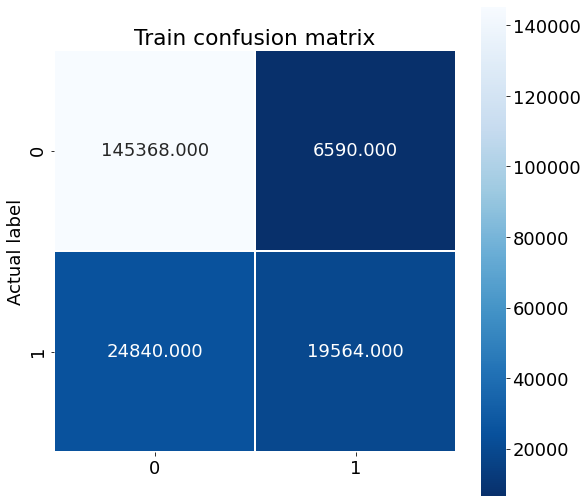

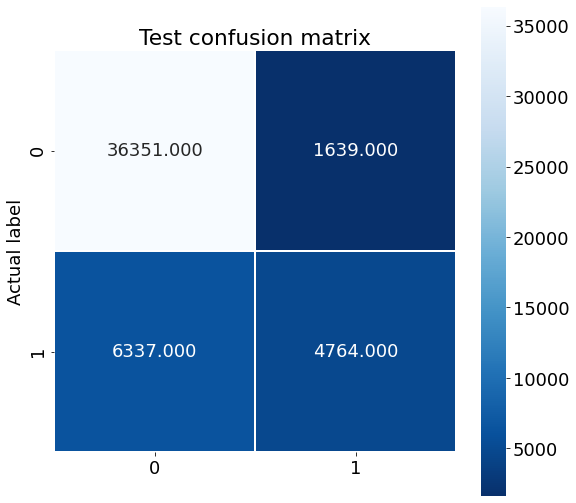

In [107]:
metric_check(rs_1.best_estimator_,X_train,X_test,y_train,y_test)

__The parameter optimization provides us better precision and accuracy but less recall. We will discuss the model metric later.__

Text(0, 0.5, 'Feature Importance Score')

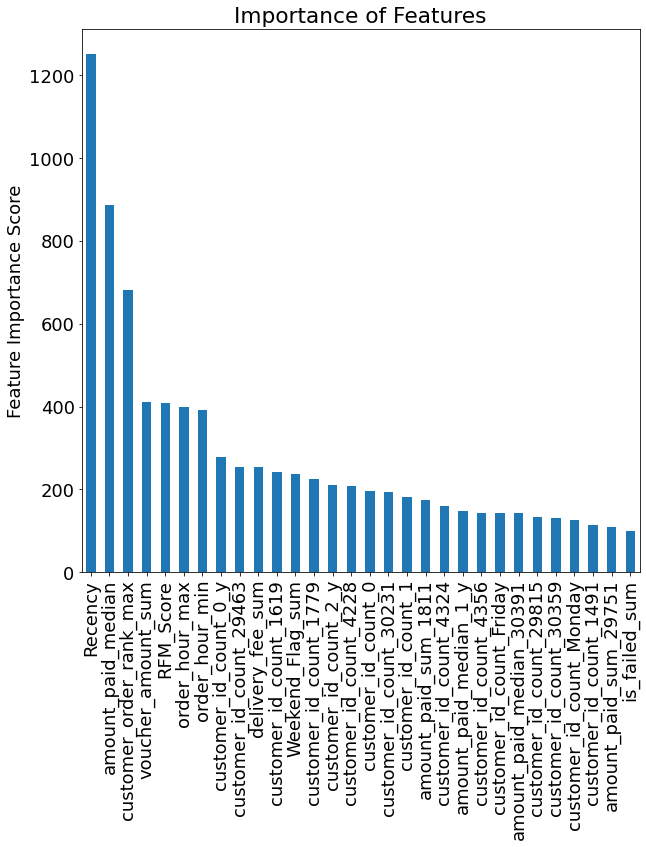

In [109]:
plt.figure(figsize=(10,10))
feat_imp = pd.Series(rs_1.best_estimator_.feature_importances_, list(X_test)).sort_values(ascending=False).head(30)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

__The graph above shows the feature importance from the lightgbm model, at the below we see the feature importances based on the Shapley value (https://www.wikipedia.com/en/Shapley_value) . They calculates feature importances considering their coalitional power. SHAP framework is also a great way for model explainibility.__ 

In [111]:
import shap
pd.set_option("display.max_columns", 96)
pd.set_option("display.max_rows", 96)

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

shap.initjs()


# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(rs_1.best_estimator_)
shap_values = explainer.shap_values(X_importance)

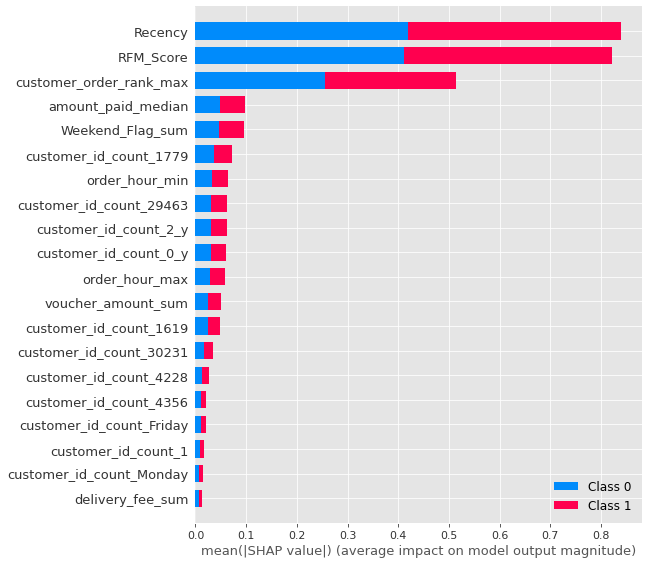

In [112]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')


In [113]:
import pickle

filename = 'rs_1_rf.pkl'
pickle.dump(rs_1.best_estimator_, open(filename, 'wb'))


__Threshold Optimization for LGBM__

__We could make a threshold optimization to balance precision and recall. We will examine it in this part but will decide in the last part we should make or not. __

In [114]:
def plot_recall_precission(recall_precision):
    plt.figure(figsize=(15, 5))
    ax = sns.pointplot(x = [element[0] for element in recall_precision], y=[element[1] for element in recall_precision], color="r", label='recall')
    ax = sns.pointplot(x = [element[0] for element in recall_precision], y=[element[2] for element in recall_precision], color="b", label='precission')

    ax.set_title('recall-precision versus threshold')
    ax.set_xlabel('threshold')
    ax.set_ylabel('probability')

    labels = ax.get_xticklabels()
    for i,l in enumerate(labels):
        if(i%5 == 0) or (i%5 ==1) or (i%5 == 2) or (i%5 == 3): labels[i] = '' # skip even labels

    ax.set_xticklabels(labels, rotation=45, fontdict={'size': 10})
    plt.show()

In [116]:
prob_predictions1 = rs_1.best_estimator_.predict_proba(X_test)[:,1]

recall_precision_lgbm = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value > threshold else 0 for value in prob_predictions1]
    recall_precision_lgbm.append([threshold, recall_score(y_test, given_threshold), precision_score(y_test, given_threshold)])


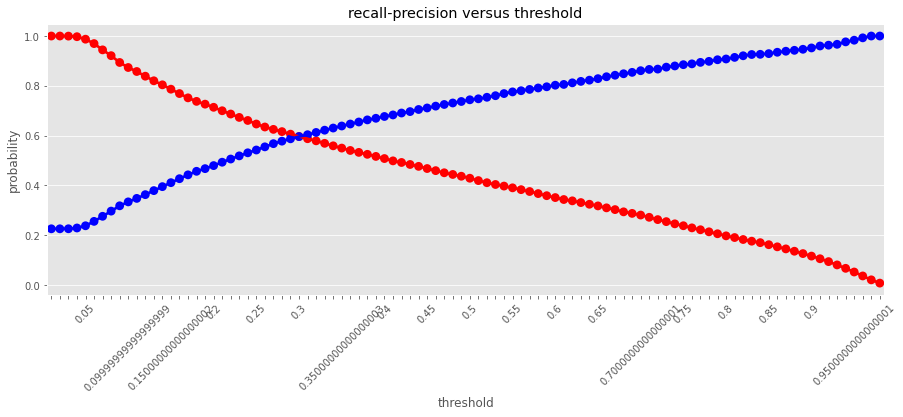

In [117]:
plot_recall_precission(recall_precision_lgbm)

In [118]:
idx = np.argwhere(np.diff(np.sign(np.asarray([element[1] for element in recall_precision_lgbm]) - np.asarray([element[2] for element in recall_precision_lgbm]))) != 0).reshape(-1) + 0
idx = idx[0]

chosen_threshold = [element[0] for element in recall_precision_lgbm][idx]
chosen_threshold

0.3

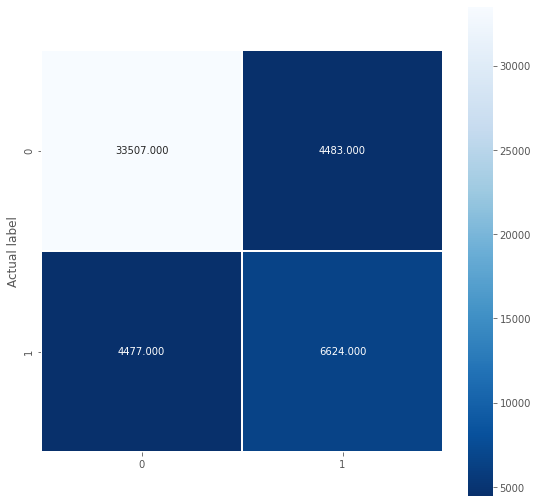

In [119]:
final_predictions_lgbm = [1 if value > chosen_threshold else 0 for value in prob_predictions1]

cm_lgbm = confusion_matrix(y_test, final_predictions_lgbm)

plt.figure(figsize=(9,9))
sns.heatmap(cm_lgbm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

__Random Forest__

__Random Forest is a bagging algorithm. Apart from boosting it does not update weak trees based on the residuals.__

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [121]:
X_train.fillna(1,inplace=True)
X_test.fillna(1,inplace=True)

In [109]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': ['gini', 'entropy']}

n_HP_points_to_test = 300

rf_random = RandomForestClassifier(random_state=12)
# Fit the random search model
rfs = RandomizedSearchCV(
    estimator=rf_random, param_distributions=random_grid, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=11,
    verbose=True,n_jobs=-1)

In [124]:
rfs.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=23, min_samples_split=10,
                       n_estimators=200, random_state=12)

In [112]:
rfs.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 23,
 'criterion': 'entropy'}

Train recall:  0.5649491036843528
Test recall:  0.4269885595892262 

Train precision:  0.9284921163668666
Test precision:  0.7395849586518958 

Train accuracy:  0.8917815055866206
Test accuracy:  0.8364262288403169 



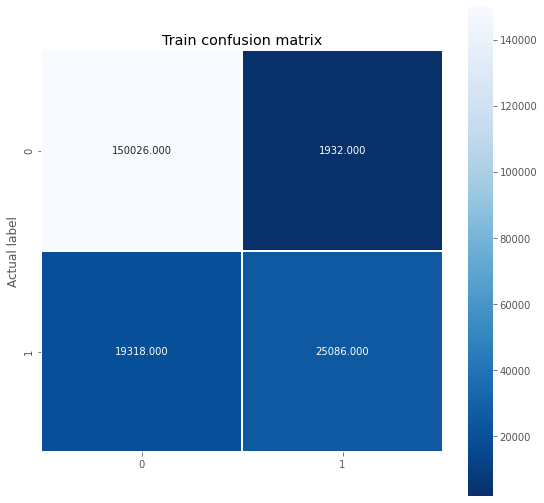

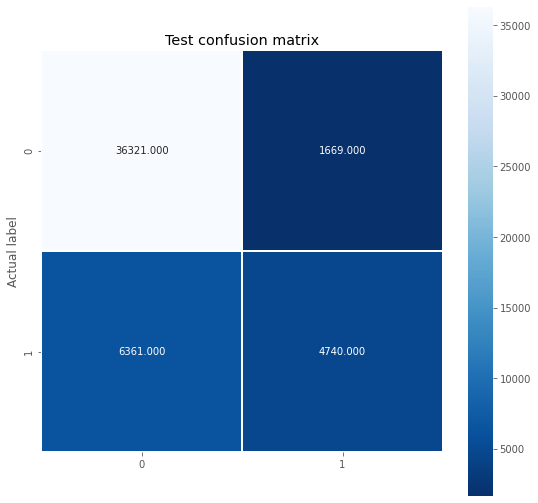

In [126]:
metric_check(rfs.best_estimator_,X_train,X_test,y_train,y_test)

In [127]:
import pickle

filename = 'rs_2_rf.pkl'
pickle.dump(rfs, open(filename, 'wb'))


## Try Another Feature Selection Algorithm

We will make the feature elimination based on the SHAPley values rather than the lightgbm s and look for the results.

In [128]:
dcust_v8 = copy.deepcopy(dcust_v7)

In [129]:
dcust_v8.drop(columns_to_delete_correlation_target, axis=1, inplace=True)

In [130]:
dcust_v8.shape

(245453, 86)

In [131]:
features = [c for c in dcust_v8.columns if c not in ['customer_id','order_date_min','order_date_max','is_returning_customer']]
target =  'is_returning_customer'

In [132]:
import gc
gc.collect()

48792

In [133]:
missing_values_table(dcust_v8[features])

Your selected dataframe has 82 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
customer_order_rank_max             518                0.2

In [134]:
dcust_v8.fillna(1,inplace=True)

In [135]:
dcust_v8['RFM_Score'] = dcust_v8['RFM_Score'].astype('int32')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(dcust_v8[features],dcust_v8[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [137]:
import shap
pd.set_option("display.max_columns", 96)
pd.set_option("display.max_rows", 96)

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

shap.initjs()


# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:


In [138]:
feature_importances = np.zeros(X_train[features].shape[1])
from lightgbm import LGBMClassifier
# Create the model with several hyperparameters


for i in range(10):
    
    model = LGBMClassifier(objective='binary', boosting_type = 'gbdt', n_estimators = 500,random_state=i)

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X_train[features], y_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'logloss', verbose = 0)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_importance)
    # Record the feature importances
    feature_importances += model.feature_importances_
    


In [139]:
feature_importances = feature_importances / 10
feature_importances = pd.DataFrame({'feature': list(X_train[features].columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))


There are 14 features with 0.0 importance


In [140]:
features_shap=[col for col in features if col not in zero_features]

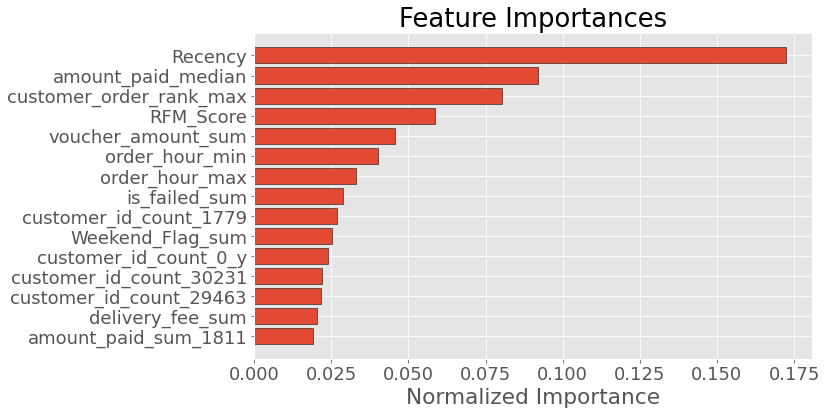

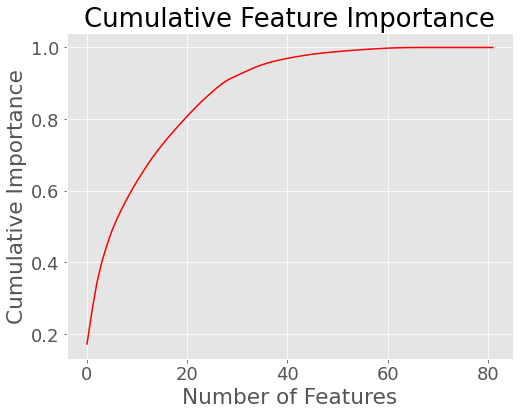

46 features required for 0.98 of cumulative importance


In [141]:
norm_feature_importances = plot_feature_importances(feature_importances,0.98)

In [142]:
threshold = 0.98

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])
features_shap=features_to_keep


In [144]:
X_train, X_test, y_train, y_test = train_test_split(dcust_v8[features_shap],dcust_v8[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [145]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(2, 50), 
             'min_child_samples': sp_randint(100, 1000), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1,1.2, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1,1.2, 5, 10, 20, 50, 100],
             'learning_rate':[0.03,0.04,0.05,0.07,0.1,0.12,0.15,0.25,0.35,0.4],
            'n_estimators':[50,100,200,300,400,500,600],
            'max_depth':[2,3,4,5,6,8,10],
            'max_bin':[50,100,195,255,350],
            'boosting_type ':['gbdt','dart']}


n_HP_points_to_test = 300

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf2 = lgb.LGBMClassifier(random_state=314, silent=True, metric='logloss', n_jobs=-1)
rs_2 = RandomizedSearchCV(
    estimator=clf2, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=11,
    verbose=True,n_jobs=-1)


rs_2.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 17.0min finished


[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='logloss', random_state=314),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'boosting_type ': ['gbdt', 'dart'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A618DD49C8>,
                                        'learning_rate': [0.03, 0.04, 0.05,
                                                          0.07, 0.1, 0.12, 0.15,
                                                          0.25, 0.35, 0.4],
                                        'max_bin': [50, 100, 195, 255, 350],
                                        'max...
                                                             10000.0],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 600],
                                        'num_leaves': <scipy.s

In [146]:
rs_2.best_params_

{'boosting_type ': 'gbdt',
 'colsample_bytree': 0.5490101571616564,
 'learning_rate': 0.03,
 'max_bin': 350,
 'max_depth': 6,
 'min_child_samples': 304,
 'min_child_weight': 0.01,
 'n_estimators': 400,
 'num_leaves': 27,
 'reg_alpha': 1.2,
 'reg_lambda': 1,
 'subsample': 0.6510570750381377}

Train recall:  0.4341951175569769
Test recall:  0.42122331321502565 

Train precision:  0.7461011570759646
Test precision:  0.7396393546346093 

Train accuracy:  0.8386398590358624
Test accuracy:  0.8355910452017682 



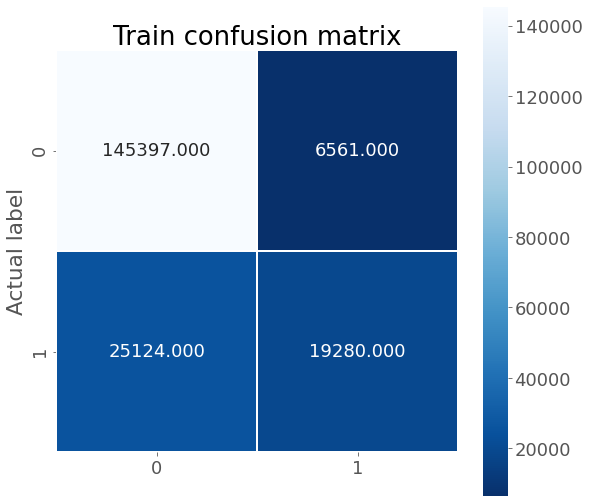

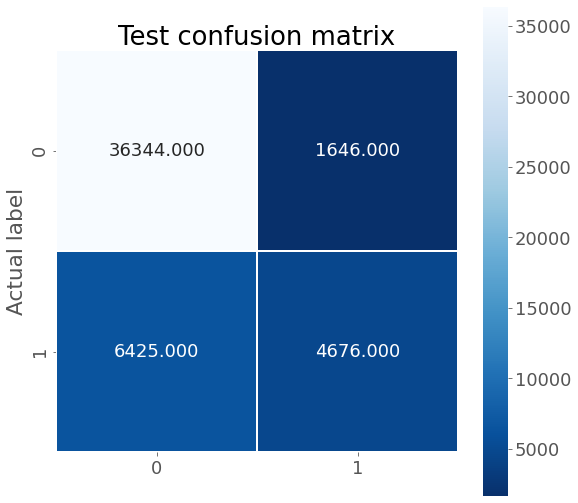

In [147]:
metric_check(rs_2.best_estimator_,X_train,X_test,y_train,y_test)

In [148]:
import pickle

filename = 'rs2_lgbm.pkl'
pickle.dump(rs_2.best_estimator_, open(filename, 'wb'))


## XGBoost 

__We will try to XGBoost which is the most famous boosting algorithm also. It works with its own datatype Dmatrix faster but we will use the scikit wrapper to avoiding translate datatypes__

In [149]:
import random
random.seed(4242)
np.random.seed(4242)

from xgboost.sklearn import XGBClassifier 


params={'boosting_type ': 'gbdt',
 'colsample_bytree': 0.5490101571616564,
 'learning_rate': 0.03,
 'max_bin': 350,
 'max_depth': 6,
 'min_child_samples': 304,
 'min_child_weight': 0.01,
 'n_estimators': 400,
 'num_leaves': 27,
 'reg_alpha': 1.2,
 'reg_lambda': 1,
 'subsample': 0.6510570750381377
       , 'objective':'binary:logistic'}


modelx = XGBClassifier(**params) 

modelx.fit(X_train, y_train)




[19:06:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { boosting_type , min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', boosting_type ='gbdt',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5490101571616564, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_bin=350, max_delta_step=0, max_depth=6,
              min_child_samples=304, min_child_weight=0.01, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_leaves=27, num_parallel_tree=1, random_state=0, reg_alpha=1.2,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6510570750381377,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train recall:  0.4442842987118278
Test recall:  0.42356544455454465 

Train precision:  0.7589735698072558
Test precision:  0.7394244378046863 

Train accuracy:  0.8424287794990885
Test accuracy:  0.8358966001914812 



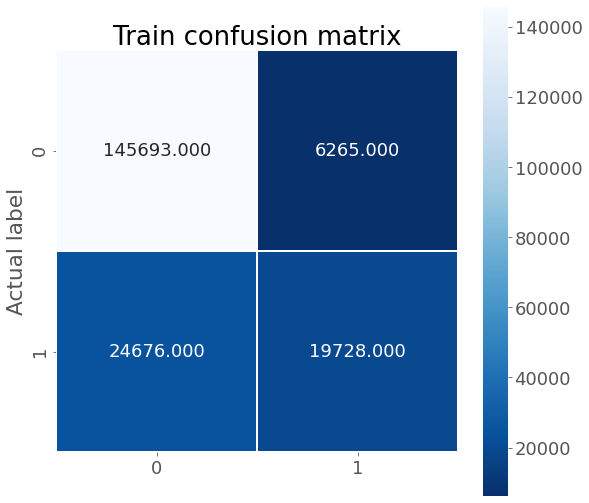

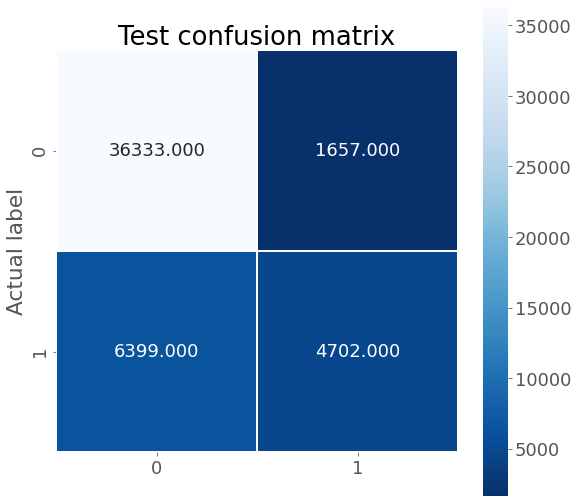

In [150]:
metric_check(modelx, X_train, X_test, y_train, y_test)

In [151]:
import pickle

filename = 'xgb_shapley.pkl'
pickle.dump(modelx, open(filename, 'wb'))


## Model Choice

In [245]:
features = copy.deepcopy(features_base)

In [249]:
def model_scores(str1,ftr):
    
    mdl = d[str1]

    start_time = time.clock()
    
    dummy = mdl.predict(X_train[ftr])
    
    work_time = time.clock() - start_time

    
    ac_tr = accuracy_score(y_train, mdl.predict(X_train[ftr]))
    ac_ts = accuracy_score(y_test, mdl.predict(X_test[ftr]))

    rc_tr = recall_score(y_train, mdl.predict(X_train[ftr]))
    rc_ts = recall_score(y_test, mdl.predict(X_test[ftr]))

    ps_tr = precision_score(y_train, mdl.predict(X_train[ftr]))
    ps_ts = precision_score(y_test, mdl.predict(X_test[ftr]))

    f1_tr = f1_score(y_train, mdl.predict(X_train[ftr]))
    f1_ts = f1_score(y_test, mdl.predict(X_test[ftr]))

    auc_tr = roc_auc_score(y_train, mdl.predict_proba(X_train[ftr])[:,1])
    auc_ts = roc_auc_score(y_test, mdl.predict_proba(X_test[ftr])[:,1])

    TN=confusion_matrix(y_test, mdl.predict(X_test[ftr]))[0][0]
    FP=confusion_matrix(y_test, mdl.predict(X_test[ftr]))[0][1]
    FN=confusion_matrix(y_test, mdl.predict(X_test[ftr]))[0][1]
    TP=confusion_matrix(y_test, mdl.predict(X_test[ftr]))[1][1]

    return pd.DataFrame([str1,ac_tr,ac_ts,rc_tr,rc_ts,ps_tr,ps_ts,f1_tr,f1_ts,auc_tr,auc_ts,TN,FP,FN,TP,work_time]).T

In [246]:
d = {'Base Parameters Catboost':model_base2, 
     'Lightgbm Random Search 1':rs_1, 
     'RF Random Search': rfs, 
     'Lightgbm Random Search 1(SHAPLEY)':rs_2, 
     'XGBoost Shapley':modelx}

In [247]:
ftrs = [c for c in dcust.columns if c not in ['customer_id','order_date_min','order_date_max','is_returning_customer']]


In [248]:
X_train, X_test, y_train, y_test = train_test_split(dcust[ftrs],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [250]:
dbench=pd.DataFrame()

In [251]:
for x in ['Base Parameters Catboost','Lightgbm Random Search 1','Lightgbm Random Search 1(SHAPLEY)','XGBoost Shapley']:
    if x in ['Base Parameters Catboost','Lightgbm Random Search 1']:
        dbench = pd.concat([dbench,model_scores(x,features)],ignore_index=False,axis=0)
    else:
        dbench = pd.concat([dbench,model_scores(x,features_shap)],ignore_index=False,axis=0)

In [252]:
#for random forest 

X_train.fillna(1,inplace=True)
X_test.fillna(1,inplace=True)

drf = model_scores('RF Random Search',features)

dbench = dbench.append(drf,ignore_index=True)

In [260]:
dbench.columns=['Model','Training Accuracy','Testing Accuracy','Recall Train','Recall Test',
                            'Precision Train','Precision Test','f1 Train','f1 Test','Auc Tr','Auc Ts','TN','FP','FN','TP','Working Time']

In [262]:
y_test.value_counts()

0    37990
1    11101
Name: is_returning_customer, dtype: int64

# Model Choice

![Precision and Recall](Precisionrecall.png)


In [261]:
dbench

Model Training Accuracy Testing Accuracy  \
0           Base Parameters Catboost          0.784266         0.782119   
1           Lightgbm Random Search 1          0.839938         0.837526   
2  Lightgbm Random Search 1(SHAPLEY)           0.83864         0.835591   
3                    XGBoost Shapley          0.842429         0.835897   
4                   RF Random Search          0.891782         0.836426   

  Recall Train Recall Test Precision Train Precision Test  f1 Train   f1 Test  \
0     0.687686    0.677416        0.517296       0.513837  0.590444  0.584395   
1     0.440591    0.429151        0.748031       0.744026  0.554551  0.544333   
2     0.434195    0.421223        0.746101       0.739639  0.548936  0.536762   
3     0.444284    0.423565        0.758974       0.739424  0.560478  0.538603   
4     0.564949    0.426989        0.928492       0.739585  0.702473  0.541405   

     Auc Tr    Auc Ts     TN    FP    FN    TP Working Time  
0  0.823961  0.817165  30875  7115  7115  7520     0.111074  
1  0.823626  0.816927  36351  1639  1639  4764      1.46195  
2  0.823002  0.815615  36344  1646  1646  4676      1.39116  
3  0.829079   0.81626  36333  1657  1657  4702      1.16003  
4  0.923776  0.813995  36321  1669  1669  4740      9.16442

## True Metric
<br>
<br>
    -> As it could be seen from the benchmark table different models performs better on different metrics.
<br>
    -> The metric choice is the most crucial part of modelling. And it depends on the usage purpose of model. 
<br>
    -> If it is a model for appylying retention campaign likely to churn, does not order, it is essential for maximizing True Negative and True Positive metrics together to prevent giving extra discount to highly loyal customer. 
<br>
    -> If the model use for cross sell campaing recommendation, catching the True Positives a little bit more important since we don't give any incentive to the customers.
<br>
    -> If it s a model for general usage for taking insights or reporting we could use AUC and F1 for finding the balance between every percentiles.
<br>
    -> If the model will be used in real time the runtime would be our star indicator in this case.

<br>
    -> I assume this model will be used for retention campaign. Since the data is not highly imbalanced and we could use <ins>Accuracy Metric.</ins>
    
<br>
    -> Since it s not overfitted and having the highest validation accuracy
    the winner is <ins> __Lightgbm Random Search 1 Model__ </ins>	
    



In [258]:
!pip3 freeze > requirements.txt
